In [1]:
import math
import json
from time import time
from random import shuffle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt


### NN ARCHITECTURES

In [2]:
# Learn semantic relatedness between two feature vectors
class SemRelNN (nn.Module):
    def __init__(self, max_score=3):
        super(SemRelNN, self).__init__()
        self.classes = max_score + 1
        self.dense = nn.Linear(1, self.classes, bias=True)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, ins1, ins2):
        inputs = ins1 * ins2
        inputs = inputs.sum(axis=1)
        inputs = inputs.reshape((-1, 1))
        logits = self.dense(inputs)
        dist = self.soft(logits)
        return dist


In [3]:
# Transfer learning from the pre-trained models
class FineTuneNN (nn.Module):
    def __init__(self, input_dim, output_dim=512, act=torch.tanh):
        super(FineTuneNN, self).__init__()
        self.in_dim = input_dim
        self.out_dim = output_dim
        self.dense1 = nn.Linear(input_dim, output_dim, bias=True)
        self.dense2 = nn.Linear(output_dim, output_dim, bias=True)
        self.act_fn = act

    def forward(self, inputs):
        out1 = self.dense1(inputs)
        act_out1 = self.act_fn(out1)
        out2 = self.dense2(act_out1)
        act_out2 = self.act_fn(out2)
        return act_out2


In [4]:
class QBESciAR (nn.Module):
    def __init__(self, baseline, facet, input_dim, max_score=3, act=torch.tanh):
        super(QBESciAR, self).__init__()
        self.baseline = baseline
        self.facet = facet
        self.fine_tuner = FineTuneNN(input_dim, input_dim, act)
        self.score_gen = SemRelNN(max_score)
        self.train_acc_step = []
        self.train_acc_epoch = []
        self.train_loss_step = []
        self.train_loss_epoch = []
        self.valid_acc = []
        self.valid_loss = []

    def forward(self, ins1, ins2):
        tuned1 = self.fine_tuner(ins1)
        tuned2 = self.fine_tuner(ins2)
        return self.score_gen(tuned1, tuned2)


### DATASET UTILITES

In [5]:
def ResampleDataset(dataset):
    sm = SMOTE(random_state=42)
    dim = len(dataset[0][0])

    X = np.array([s[0] + s[1] for s in dataset])
    Y = np.array([s[2] for s in dataset])
    X, Y = sm.fit_resample(X, Y)

    l = Y.shape[0]
    data = [(X[i][:dim], X[i][dim:], Y[i]) for i in range(l)]
    return data


In [6]:
def PrepareDataset(baseline, facet):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)

    query_feature_data_file_name = 'data/' + baseline + '/' + facet + '.json'
    query_feature_data_file = open(query_feature_data_file_name)
    query_feature_data = json.load(query_feature_data_file)

    cand_feature_data_file_name = 'data/' + baseline + '/all.json'
    cand_feature_data_file = open(cand_feature_data_file_name)
    cand_feature_data = json.load(cand_feature_data_file)

    data = []
    for q in rank_data.keys():
        qvec = query_feature_data[q]
        l = len(rank_data[q]['cands'])
        for i in range(l):
            cand = rank_data[q]['cands'][i]
            score = rank_data[q]['relevance_adju'][i]
            data.append((qvec, cand_feature_data[cand], score))

    rank_data_file.close()
    query_feature_data_file.close()
    cand_feature_data_file.close()

    data = ResampleDataset(data)
    return data


In [7]:
def ReFormatAbstractData():
    abstract_data = dict()
    with open('data/abstracts-csfcube-preds.jsonl', 'r') as abstract_file:
        json_list = list(abstract_file)
    for json_str in json_list:
        line = json.loads(json_str)
        abstract_data[line['paper_id']] = line
    with open('data/abstracts-csfcube-preds.json', 'w') as formatted_abstract_file:
        json.dump(abstract_data, formatted_abstract_file)


In [8]:
# ReFormatAbstractData()

In [9]:
def SplitDataset(data, tr_v_te_ratio=[0.40, 0.15, 0.45]):
    tr_v_te_ratio = [_ / sum(tr_v_te_ratio) for _ in tr_v_te_ratio]
    tr_s = int(tr_v_te_ratio[0] * len(data))
    vl_s = int(tr_v_te_ratio[1] * len(data))
    te_s = len(data) - tr_s - vl_s

    shuffle(data)
    train_data = data[:tr_s]
    valid_data = data[tr_s:(tr_s+vl_s)]
    test_data = data[(tr_s+vl_s):]

    return train_data, valid_data, test_data


### TRAINING UTILITIES

In [10]:
sigma = np.sqrt(2/np.pi)
from scipy.ndimage import gaussian_filter1d

In [11]:
def MakeBatches(dataset, batch_size=16):
    shuffle(dataset)
    batches = list()
    for start in range(0, len(dataset), batch_size):
        end = start + batch_size
        ins1, ins2, outs = list(zip(*dataset[start:end]))
        outs = np.array(outs)
        n_values = 4
        outs = np.eye(n_values)[outs]
        outs = gaussian_filter1d(outs, sigma)
        ins1, ins2, outs = torch.tensor(ins1).float(), torch.tensor(
            ins2).float(), torch.tensor(outs).float()
        batches.append((ins1, ins2, outs))
    return batches


In [12]:
def Train(train_data, val_data, baseline, facet,
          epochs=500, lr=0.01, batch_size=16,
          early_stopping_tolerance=4,
          desirable_train_acc=0.95):

    input_dim = len(train_data[0][0])
    MODEL = QBESciAR(baseline, facet, input_dim, max_score=3)

    loss_fn = nn.KLDivLoss(reduction="batchmean")
    optimizer = torch.optim.Adam(MODEL.parameters(), lr=lr)
    consec_inc = 0
    prev_valid_loss = float('inf')

    for epoch in range(epochs):
        total_loss = 0.0
        batches = MakeBatches(train_data, batch_size)
        epoch_start_time = time()
        correct_preds = 0
        total_samples = 0

        for step, (ins1, ins2, true) in enumerate(batches):
            pred = MODEL(ins1, ins2)
            pred_labels = torch.argmax(pred, dim=1)
            true_labels = torch.argmax(true, dim=1)

            loss = loss_fn(pred, true)

            total_loss += loss
            c = (pred_labels == true_labels).sum()
            correct_preds += c
            total_samples += true.shape[0]

            MODEL.train_loss_step.append(loss)
            MODEL.train_acc_step.append(c / true.shape[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = total_loss / len(batches)
        acc = correct_preds / total_samples
        ti = time() - epoch_start_time

        val_acc, val_loss = AccLoss(val_data, loss_fn, MODEL)

        MODEL.train_acc_epoch.append(acc)
        MODEL.train_loss_epoch.append(mean_loss)
        MODEL.valid_acc.append(val_acc)
        MODEL.valid_loss.append(val_loss)

        logg = ' EPOCH {:3d} | T.LOSS : {:2.6f} | T.ACC : {:3f} | V.LOSS : {:.6f} | V.ACC : {:3f} | DUR : {:.4f}'
        print(logg.format(epoch+1, mean_loss, acc, val_loss, val_acc, ti))

        if (acc >= desirable_train_acc):
            print('\n [ EARLY STOPPING : DESIRABLE TRAINING ACCURACY REACHED ! ]')
            break

        if (prev_valid_loss < val_loss):
            consec_inc += 1
        else:
            consec_inc = 0
        prev_valid_loss = val_loss

        if (consec_inc == early_stopping_tolerance):
            print('\n [ EARLY STOPPING : VALIDATION LOSS NOT DECREASING ! ]')
            break

    MODEL.eval()
    model_name = baseline + '/' + facet + '.qbe'
    torch.save(MODEL, 'models-KLDivLoss/' + model_name)
    return MODEL


### PLOT UTILITIES

In [13]:
def GetContingencyMatrix(true, pred):
    mat = np.zeros((4, 4))
    l = len(true)
    for i in range(l):
        mat[pred[i]][true[i]] += 1
    return mat


In [14]:
def PlotAndSaveContingencyMatrix(true, pred, loc):
    contingency_mat = GetContingencyMatrix(true, pred)
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.heatmap(contingency_mat)
    ax.set_xlabel('TRUE SCORES', fontsize=13)
    ax.set_ylabel('PREDICTED SCORES', fontsize=13)
    plt.show()
    fig.savefig(loc)


In [15]:
def PlotAccuracyProgress(train_step_hist, train_epoch_hist, valid_hist, loc):
    steps = len(train_step_hist)
    epochs = len(train_epoch_hist)
    r = steps / epochs

    xe = np.array(range(epochs)) * r
    xs = np.array(range(steps))

    fontsize = 12
    plt.style.use('seaborn-whitegrid')
    currentAxis = plt.gca()
    currentAxis.plot(xe, train_epoch_hist, linewidth=2.5)
    currentAxis.plot(xe, valid_hist, linewidth=1.8)
    currentAxis.plot(xs, train_step_hist, linewidth=1, color='C3', alpha=0.5)

    plt.legend(["TRAIN-SET (epoch-wise)", "VALID-SET (epoch-wise)",
                "TRAIN-SET (step-wise)"], loc="lower right")

    plt.xlabel('STEP / EPOCH', fontsize=fontsize)
    plt.ylabel('ACCURACY', fontsize=fontsize)
    plt.title('PROGRESS OF ACCURACY', fontsize=13, fontweight='bold')
    plt.savefig('plots-KLDivLoss/' + loc)
    plt.show()


In [16]:
def PlotLossProgress(train_step_hist, train_epoch_hist, valid_hist, loc):
    steps = len(train_step_hist)
    epochs = len(train_epoch_hist)
    r = steps / epochs

    xe = np.array(range(epochs)) * r
    xs = np.array(range(steps))

    fontsize = 12
    plt.style.use('seaborn-whitegrid')
    currentAxis = plt.gca()
    currentAxis.plot(xe, train_epoch_hist, linewidth=2.5)
    currentAxis.plot(xe, valid_hist, linewidth=1.8)
    currentAxis.plot(xs, train_step_hist, linewidth=1, color='C3', alpha=0.5)

    plt.legend(["TRAIN-SET (epoch-wise)", "VALID-SET (epoch-wise)",
                "TRAIN-SET (step-wise)"], loc="upper right")

    plt.xlabel('STEP / EPOCH', fontsize=fontsize)
    plt.ylabel('LOSS', fontsize=fontsize)
    plt.title('PROGRESS OF LOSS', fontsize=13, fontweight='bold')
    plt.savefig('plots-KLDivLoss/' + loc)
    plt.show()


### COGNITIVE EVALUATION

In [17]:
def GetQueryFeature(baseline, facet, paper_id):
    query_feature_data_file_name = 'data/' + baseline + '/' + facet + '.json'
    query_feature_data_file = open(query_feature_data_file_name)
    query_feature_data = json.load(query_feature_data_file)
    query_feature_data_file.close()
    return query_feature_data[paper_id]


def GetCandidateFeatures(baseline, facet, paper_id):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)

    cand_feature_data_file_name = 'data/' + baseline + '/all.json'
    cand_feature_data_file = open(cand_feature_data_file_name)
    cand_feature_data = json.load(cand_feature_data_file)

    rank_data_file.close()
    cand_feature_data_file.close()

    cand_features = [cand_feature_data[cand_pid]
                     for cand_pid in rank_data[paper_id]['cands']]
    return rank_data[paper_id]['cands'], cand_features


In [18]:
def QBERetrieveSciArticles(baseline, facet, paper_id, top=True, ret_k=15):
    qf = GetQueryFeature(baseline, facet, paper_id)
    cand_pids, cand_f = GetCandidateFeatures(baseline, facet, paper_id)
    cand_c = len(cand_f)

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-KLDivLoss/' + model_name)
    model.eval()

    ins1, ins2 = [qf] * cand_c, cand_f
    ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

    pred = model(ins1, ins2)
    pred_labels = torch.argmax(pred, dim=1).numpy()
    pred = pred.detach().numpy()
    rank_scores = [l + (l != 0) * pred[i][l] + (l == 0) * (1 - pred[i][0])
                   for i, l in enumerate(pred_labels)]

    scored_cands = list(zip(cand_pids, rank_scores))
    scored_cands.sort(key=lambda x: -1 * x[1])

    abstract_data_file = open('data/abstracts-csfcube-preds.json')
    abstract_data = json.load(abstract_data_file)
    abstract_data_file.close()

    results = None
    if top:
        results = scored_cands[:ret_k]
    else:
        results = scored_cands[-ret_k:]
        results.reverse()

    print('\n >>> BASELINE : ' + baseline + ' <<<')
    print(' >>> FACET : ' + facet + ' <<<')

    print('\n +++ QUERY PAPER +++\n')
    print(' [ TITLE ] ' + abstract_data[paper_id]['title'])
    print(' [ ABSTRACT ] ')
    for sent in abstract_data[paper_id]['abstract']:
        print('', sent)

    if top:
        print('\n +++ TOP {} PAPERS +++\n'.format(ret_k))
    else:
        print('\n +++ BOTTOM {} PAPERS +++\n'.format(ret_k))

    for rank, (pid, score) in enumerate(results):
        print(' RANK : {} | PAPER I.D. : {} | GRADED RELEVANCE SCORE : {:.4f}'.format(
            rank+1, pid, score))
        print(' [ TITLE ] ' + abstract_data[pid]['title'])
        print(' [ ABSTRACT ] ')
        for sent in abstract_data[pid]['abstract']:
            print('', sent)
        print('\n')


### ANALYTICAL EVALUATION

In [19]:
def AccLoss(data, loss_fn, MODEL):
    batches = MakeBatches(data)
    total_loss = 0
    correct_preds = 0
    total_samples = 0

    for __, (ins1, ins2, true) in enumerate(batches):
        pred = MODEL(ins1, ins2)
        pred_labels = torch.argmax(pred, dim=1)
        true_labels = torch.argmax(true, dim=1)

        loss = loss_fn(pred, true)

        total_loss += loss.item()
        correct_preds += (pred_labels == true_labels).sum()
        total_samples += true.shape[0]

    mean_loss = total_loss / len(batches)
    acc = correct_preds / total_samples
    return acc, mean_loss


def Pred(data, MODEL):
    preds = []

    for in1, in2, __ in data:
        in1 = in1.reshape((1, -1))
        in2 = in2.reshape((1, -1))
        in1, in2 = torch.tensor(in1).float(), torch.tensor(in2).float()
        pred = MODEL(in1, in2)
        pred_label = torch.argmax(pred, dim=1)
        preds.append(pred_label.item())

    return preds


In [20]:
def GetMSE(x, y):
    x, y = np.array(x), np.array(y)
    return ((x - y) ** 2).mean()


In [21]:
def DCG(rank_scores, K=100):
    score = rank_scores[0]
    l = int(len(rank_scores) * (K/100))
    for i in range(1, l):
        score += rank_scores[i] / math.log2(i + 1)
    return score


def NDCG(pred_scores, ideal_scores, K=100):
    return DCG(pred_scores, K) / DCG(ideal_scores, K)


def AllNDCG(baseline, facet, K=100):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-KLDivLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    all_ndcg = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)
        ideal_ranking_scores = true_labels
        ideal_ranking_scores.sort(reverse=True)

        ndcg = NDCG(pred_ranking_scores, ideal_ranking_scores, K)
        all_ndcg.append(ndcg)

    return np.array(all_ndcg)


In [22]:
def PrecisionAtK(pred_ranking_scores, K):
    pred_ranking_scores = pred_ranking_scores[:K]
    K = len(pred_ranking_scores)
    return len([_ for _ in pred_ranking_scores if _ > 1]) / K


def MeanPrecisionAtK(baseline, facet, K=20, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-KLDivLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        prec_at_k = PrecisionAtK(pred_ranking_scores, K)
        values.append(prec_at_k)

    if (not need_list):
        return sum(values) / len(values)
    return values


In [23]:
def RecallAtK(pred_ranking_scores, K):
    tot = len([_ for _ in pred_ranking_scores if _ > 1])
    pred_ranking_scores = pred_ranking_scores[:K]
    return len([_ for _ in pred_ranking_scores if _ > 1]) / tot


def MeanRecallAtK(baseline, facet, K=20, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-KLDivLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        recall_at_k = RecallAtK(pred_ranking_scores, K)
        values.append(recall_at_k)

    if (not need_list):
        return sum(values) / len(values)
    return values


In [24]:
def AveragePrecision(pred_ranking_scores):
    precs = []
    count = 0
    for it, rel in enumerate(pred_ranking_scores):
        if (rel == 1):
            continue
        count += 1
        precs.append(count / (it + 1))
    return sum(precs) / len(precs)


def MeanAveragePrecision(baseline, facet, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-KLDivLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        avg_prec = AveragePrecision(pred_ranking_scores)
        values.append(avg_prec)

    if (not need_list):
        return sum(values) / len(values)
    return values


In [25]:
def RPrecision(pred_ranking_scores):
    tot = len([_ for _ in pred_ranking_scores if _ > 1])
    pred_ranking_scores = pred_ranking_scores[:tot]
    return len([_ for _ in pred_ranking_scores if _ > 1]) / tot


def MeanRPrecision(baseline, facet, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-KLDivLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        r_prec = RPrecision(pred_ranking_scores)
        values.append(r_prec)

    if (not need_list):
        return sum(values) / len(values)
    return values


### AGGREGATED EVALUATION

In [26]:
def AggregatedNDCG(baseline, K=100):
    facets = ['background', 'result', 'method']
    all_ndcgs = []
    for facet in facets:
        all_ndcgs = np.concatenate((all_ndcgs, AllNDCG(baseline, facet, K)))
    return all_ndcgs


In [27]:
def AggregatedMeanPrecisionAtK(baseline, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanPrecisionAtK(baseline, facet, K, True))
    return sum(values) / len(values)


def AggregatedMeanRecallAtK(baseline, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanRecallAtK(baseline, facet, K, True))
    return sum(values) / len(values)


def AggregatedMeanRPrecision(baseline):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanRPrecision(baseline, facet, True))
    return sum(values) / len(values)


def AggregatedMeanAveragePrecision(baseline):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanAveragePrecision(baseline, facet, True))
    return sum(values) / len(values)


In [28]:
def EvaluateOnAllQueries(baseline):
    ndcg_all_queries = AggregatedNDCG(baseline)
    print(' > (AGG) MEAN NDCG (@100%) : {:.2f} %'.format(
        100 * ndcg_all_queries.mean()))
    print(
        ' > (AGG) STD-DEV in NDCG (@100%) : {:.2f} %'.format(100 * ndcg_all_queries.std()))
    ndcg_20 = AggregatedNDCG(baseline, K=20)
    print(' > (AGG) MEAN NDCG (@20%) : {:.2f} %'.format(
        100 * ndcg_20.mean()))
    print(
        ' > (AGG) STD-DEV in NDCG (@20%) : {:.2f} %'.format(100 * ndcg_20.std()))
    print(' > (AGG) MEAN PRECISION@20 : {:.2f} %'.format(
        100 * AggregatedMeanPrecisionAtK(baseline, K=20)))
    print(' > (AGG) MEAN RECALL@20 : {:.2f} %'.format(
        100 * AggregatedMeanRecallAtK(baseline, K=20)))
    print(' > (AGG) MEAN R PRECISION : {:.2f} %'.format(
        100 * AggregatedMeanRPrecision(baseline)))
    print(' > (AGG) MEAN AVG. PRECISION : {:.2f} %'.format(
        100 * AggregatedMeanAveragePrecision(baseline)))


### TESTING & EVALUATION UTILITIES

In [29]:
def EvaluateOnTestData01(test_data, model, baseline, facet):
    preds = Pred(test_data, model)
    true = list(list(zip(*test_data))[2])
    mat = GetContingencyMatrix(true, preds)

    print('\n +++ CONTINGENCY MATRIX +++')
    print(mat)

    loc = 'plots-KLDivLoss/' + baseline + '/' + facet + '_conting_mat'
    PlotAndSaveContingencyMatrix(true, preds, loc)


In [30]:
def EvaluateOnTestData02(test_data, model):
    preds = Pred(test_data, model)
    true = list(list(zip(*test_data))[2])

    loss_fn = nn.KLDivLoss(reduction="batchmean")
    acc, loss = AccLoss(test_data, loss_fn, model)

    print(' > LOSS : {:.4f}'.format(loss))
    print(' > ACCURACY : {:.4f}'.format(acc.item()))
    print(' > MEAN SQUARED ERR : {:.4f}'.format(GetMSE(preds, true)))


In [31]:
def EvaluateOnAllFacetQueries(baseline, facet):
    print(' > MEAN PRECISION@20 : {:.2f} %'.format(
        100 * MeanPrecisionAtK(baseline, facet, K=20)))
    print(' > MEAN RECALL@20 : {:.2f} %'.format(
        100 * MeanRecallAtK(baseline, facet, K=20)))
    print(' > MEAN R PRECISION : {:.2f} %'.format(
        100 * MeanRPrecision(baseline, facet)))
    print(' > MEAN AVG. PRECISION : {:.2f} %'.format(
        100 * MeanAveragePrecision(baseline, facet)))


### IMPLEMENTATION (INDIVIDUAL)

In [32]:
def Implement(baseline, facet, train=False):
    data = PrepareDataset(baseline, facet)
    train_data, valid_data, test_data = SplitDataset(data)

    print('\n > BASELINE :', baseline)
    print(' > FACET :', facet)
    print('\n', end='')

    model = None
    if (train):
        model = Train(train_data, valid_data, baseline, facet, lr=0.001,
                      epochs=300, batch_size=16, early_stopping_tolerance=4)
    else:
        model_name = baseline + '/' + facet + '.qbe'
        model = torch.load('models-KLDivLoss/' + model_name)

    print('\n', model.eval())

    PlotAccuracyProgress(model.train_acc_step, model.train_acc_epoch,
                         model.valid_acc, baseline + '/' + facet + '_acc')

    PlotLossProgress(model.train_loss_step, model.train_loss_epoch,
                     model.valid_loss, baseline + '/' + facet + '_loss')

    print('\n', end='')
    EvaluateOnTestData01(test_data, model, baseline, facet)

    print('\n', end='')
    EvaluateOnTestData02(test_data, model)

    print('\n', end='')
    EvaluateOnAllFacetQueries(baseline, facet)

    ndcg_all_queries = AllNDCG(baseline, facet)
    print('\n > MEAN NDCG (@100%) : {:5f}'.format(ndcg_all_queries.mean()))
    print(' > (STD) DEV in NDCG (@100%) : {:5f}'.format(ndcg_all_queries.std()))

    ndcg_all_queries_20 = AllNDCG(baseline, facet, K=20)
    print('\n > MEAN NDCG (@20%) : {:5f}'.format(ndcg_all_queries_20.mean()))
    print(' > (STD) DEV in NDCG (@20%) : {:5f}'.format(ndcg_all_queries_20.std()))


### IMPLEMENTATION (ENSEMBLE)

In [33]:
def EnsembleNDCG(baselines, K=100):
    facets = ['background', 'result', 'method']
    all_ndcgs = np.array([])
    for t, facet in enumerate(facets):
        all_ndcgs = np.concatenate((all_ndcgs, AllNDCG(baselines[t], facet, K)))
    return all_ndcgs


In [34]:
def EnsembleMeanPrecisionAtK(baselines, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanPrecisionAtK(baselines[t], facet, K, True))
    return sum(values) / len(values)


def EnsembleMeanRecallAtK(baselines, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanRecallAtK(baselines[t], facet, K, True))
    return sum(values) / len(values)


def EnsembleMeanRPrecision(baselines):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanRPrecision(baselines[t], facet, True))
    return sum(values) / len(values)


def EnsembleMeanAveragePrecision(baselines):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanAveragePrecision(baselines[t], facet, True))
    return sum(values) / len(values)


In [35]:
def EnsembleEvaluateOnAllQueries(baselines):
    ndcg_all_queries = EnsembleNDCG(baselines)
    print(' > (AGG) MEAN NDCG (@100%) : {:.2f} %'.format(100*ndcg_all_queries.mean()))
    print(
        ' > (AGG) STD-DEV in NDCG (@100%) : {:.2f} %'.format(100*ndcg_all_queries.std()))
    ndcg_all_queries = EnsembleNDCG(baselines, K=20)
    print(' > (AGG) MEAN NDCG (@20%) : {:.2f} %'.format(100*ndcg_all_queries.mean()))
    print(
        ' > (AGG) STD-DEV in NDCG (@20%) : {:.2f} %'.format(100*ndcg_all_queries.std()))
    print(' > (AGG) MEAN PRECISION@20 : {:.2f} %'.format(
        100*EnsembleMeanPrecisionAtK(baselines, K=20)))
    print(' > (AGG) MEAN RECALL@20 : {:.2f} %'.format(
        100*EnsembleMeanRecallAtK(baselines, K=20)))
    print(' > (AGG) MEAN R PRECISION : {:.2f} %'.format(
        100*EnsembleMeanRPrecision(baselines)))
    print(' > (AGG) MEAN AVG. PRECISION : {:.2f} %'.format(
        100*EnsembleMeanAveragePrecision(baselines)))


## BERT-based NLI Baseline (bert_nli)

### [ BACKGROUND ]


 > BASELINE : bert_nli
 > FACET : background

 EPOCH   1 | T.LOSS : 0.714898 | T.ACC : 0.283965 | V.LOSS : 0.509517 | V.ACC : 0.304821 | DUR : 2.3788
 EPOCH   2 | T.LOSS : 0.537680 | T.ACC : 0.324198 | V.LOSS : 0.754218 | V.ACC : 0.255054 | DUR : 1.4657
 EPOCH   3 | T.LOSS : 0.489248 | T.ACC : 0.372012 | V.LOSS : 0.433726 | V.ACC : 0.437014 | DUR : 1.4613
 EPOCH   4 | T.LOSS : 0.430706 | T.ACC : 0.479883 | V.LOSS : 0.377088 | V.ACC : 0.493002 | DUR : 1.4708
 EPOCH   5 | T.LOSS : 0.386474 | T.ACC : 0.514286 | V.LOSS : 0.367683 | V.ACC : 0.491446 | DUR : 1.4564
 EPOCH   6 | T.LOSS : 0.356205 | T.ACC : 0.484548 | V.LOSS : 0.313356 | V.ACC : 0.471229 | DUR : 1.4827
 EPOCH   7 | T.LOSS : 0.250602 | T.ACC : 0.596501 | V.LOSS : 0.268902 | V.ACC : 0.525661 | DUR : 1.4368
 EPOCH   8 | T.LOSS : 0.201469 | T.ACC : 0.627405 | V.LOSS : 0.217048 | V.ACC : 0.645412 | DUR : 1.3539
 EPOCH   9 | T.LOSS : 0.160360 | T.ACC : 0.692711 | V.LOSS : 0.195763 | V.ACC : 0.608087 | DUR : 1.2833
 EPOCH  10 | T.LO

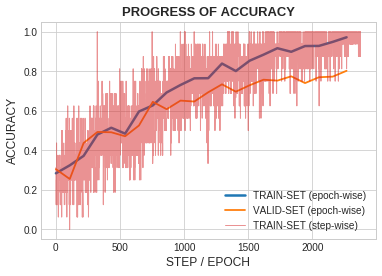

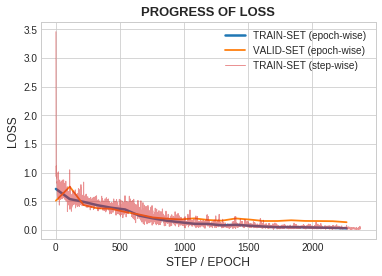



 +++ CONTINGENCY MATRIX +++
[[307.  95.   1.   0.]
 [144. 335.  42.   0.]
 [ 26.  57. 408.   0.]
 [  5.   5.   5. 500.]]


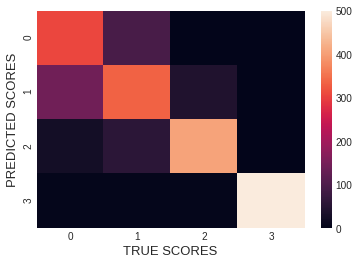


 > LOSS : 0.1494
 > ACCURACY : 0.8031
 > MEAN SQUARED ERR : 0.2674

 > MEAN PRECISION@20 : 50.63 %
 > MEAN RECALL@20 : 81.61 %
 > MEAN R PRECISION : 66.54 %
 > MEAN AVG. PRECISION : 67.89 %

 > MEAN NDCG (@100%) : 0.910672
 > (STD) DEV in NDCG (@100%) : 0.052749

 > MEAN NDCG (@20%) : 0.829543
 > (STD) DEV in NDCG (@20%) : 0.075805


In [36]:
baseline = 'bert_nli'
facet = 'background'
Implement(baseline, facet, train=True)

In [37]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : bert_nli <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using

### [ METHOD ]


 > BASELINE : bert_nli
 > FACET : method

 EPOCH   1 | T.LOSS : 2.292563 | T.ACC : 0.307578 | V.LOSS : 1.712228 | V.ACC : 0.319128 | DUR : 1.9204
 EPOCH   2 | T.LOSS : 1.258154 | T.ACC : 0.335438 | V.LOSS : 0.942785 | V.ACC : 0.418236 | DUR : 2.0556
 EPOCH   3 | T.LOSS : 0.858546 | T.ACC : 0.434250 | V.LOSS : 1.001304 | V.ACC : 0.514371 | DUR : 1.9686
 EPOCH   4 | T.LOSS : 1.079778 | T.ACC : 0.453938 | V.LOSS : 0.666639 | V.ACC : 0.502478 | DUR : 1.9183
 EPOCH   5 | T.LOSS : 0.468700 | T.ACC : 0.545691 | V.LOSS : 0.341619 | V.ACC : 0.593657 | DUR : 1.8935
 EPOCH   6 | T.LOSS : 0.232263 | T.ACC : 0.639302 | V.LOSS : 0.233422 | V.ACC : 0.591675 | DUR : 1.9374
 EPOCH   7 | T.LOSS : 0.206465 | T.ACC : 0.658247 | V.LOSS : 0.238913 | V.ACC : 0.589693 | DUR : 1.8905
 EPOCH   8 | T.LOSS : 0.140892 | T.ACC : 0.731055 | V.LOSS : 0.178328 | V.ACC : 0.706640 | DUR : 1.8255
 EPOCH   9 | T.LOSS : 0.124579 | T.ACC : 0.753343 | V.LOSS : 0.166485 | V.ACC : 0.668979 | DUR : 1.8575
 EPOCH  10 | T.LOSS :

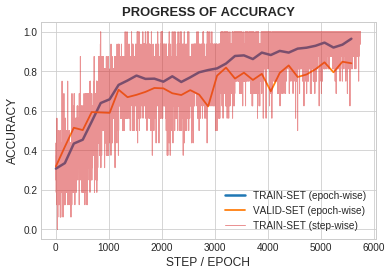

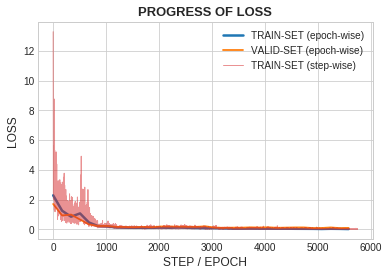



 +++ CONTINGENCY MATRIX +++
[[482. 130.   0.   0.]
 [268. 560.  32.   0.]
 [ 46.  21. 716.   0.]
 [  3.   0.  11. 762.]]


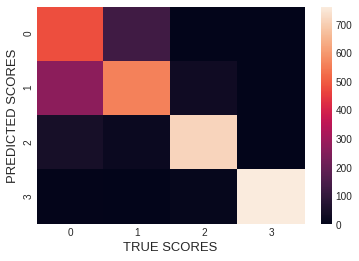


 > LOSS : 0.1230
 > ACCURACY : 0.8314
 > MEAN SQUARED ERR : 0.2220

 > MEAN PRECISION@20 : 32.65 %
 > MEAN RECALL@20 : 97.62 %
 > MEAN R PRECISION : 61.17 %
 > MEAN AVG. PRECISION : 78.31 %

 > MEAN NDCG (@100%) : 0.829731
 > (STD) DEV in NDCG (@100%) : 0.089845

 > MEAN NDCG (@20%) : 0.690328
 > (STD) DEV in NDCG (@20%) : 0.139126


In [38]:
baseline = 'bert_nli'
facet = 'method'
Implement(baseline, facet, train=True)


In [39]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : bert_nli <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subseq

### [ RESULTS ]


 > BASELINE : bert_nli
 > FACET : result

 EPOCH   1 | T.LOSS : 0.789626 | T.ACC : 0.388298 | V.LOSS : 0.484427 | V.ACC : 0.389058 | DUR : 1.9264
 EPOCH   2 | T.LOSS : 0.402815 | T.ACC : 0.436170 | V.LOSS : 0.430246 | V.ACC : 0.396150 | DUR : 1.9307
 EPOCH   3 | T.LOSS : 0.341135 | T.ACC : 0.490502 | V.LOSS : 0.369960 | V.ACC : 0.467072 | DUR : 1.9189
 EPOCH   4 | T.LOSS : 0.234492 | T.ACC : 0.554711 | V.LOSS : 0.225259 | V.ACC : 0.608916 | DUR : 1.9428
 EPOCH   5 | T.LOSS : 0.183217 | T.ACC : 0.629939 | V.LOSS : 0.188492 | V.ACC : 0.618034 | DUR : 1.9268
 EPOCH   6 | T.LOSS : 0.140030 | T.ACC : 0.678191 | V.LOSS : 0.188656 | V.ACC : 0.616008 | DUR : 1.9792
 EPOCH   7 | T.LOSS : 0.120768 | T.ACC : 0.720745 | V.LOSS : 0.151531 | V.ACC : 0.717325 | DUR : 1.9073
 EPOCH   8 | T.LOSS : 0.109929 | T.ACC : 0.754939 | V.LOSS : 0.155158 | V.ACC : 0.751773 | DUR : 1.9083
 EPOCH   9 | T.LOSS : 0.091153 | T.ACC : 0.799012 | V.LOSS : 0.148897 | V.ACC : 0.760892 | DUR : 1.8198
 EPOCH  10 | T.LOSS :

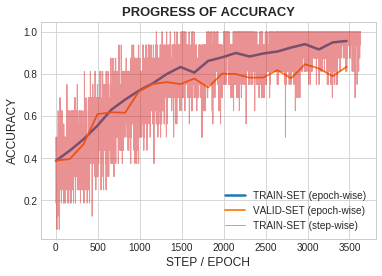

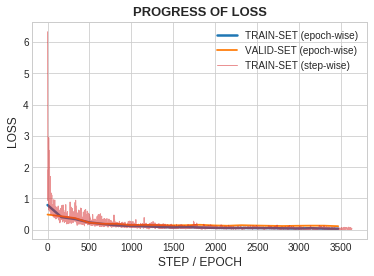



 +++ CONTINGENCY MATRIX +++
[[490. 147.   0.   0.]
 [214. 560.  17.   0.]
 [ 32.  14. 703.   0.]
 [  0.   0.  10. 774.]]


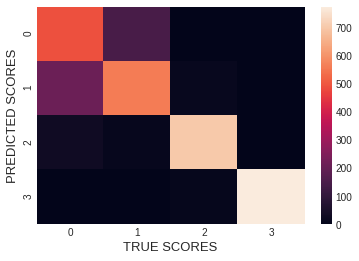


 > LOSS : 0.0980
 > ACCURACY : 0.8534
 > MEAN SQUARED ERR : 0.1790

 > MEAN PRECISION@20 : 45.00 %
 > MEAN RECALL@20 : 97.11 %
 > MEAN R PRECISION : 77.49 %
 > MEAN AVG. PRECISION : 77.09 %

 > MEAN NDCG (@100%) : 0.909675
 > (STD) DEV in NDCG (@100%) : 0.054152

 > MEAN NDCG (@20%) : 0.819350
 > (STD) DEV in NDCG (@20%) : 0.092264


In [40]:
baseline = 'bert_nli'
facet = 'result'
Implement(baseline, facet, train=True)


In [41]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : bert_nli <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 10076790 | GRADED RELEVANCE SCORE : 2.7569
 [ TITLE ] Mo

### [ AGGREGATED ]

In [37]:
baseline = 'bert_nli'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 88.28 %
 > (AGG) STD-DEV in NDCG (@100%) : 7.80 %
 > (AGG) MEAN NDCG (@20%) : 77.87 %
 > (AGG) STD-DEV in NDCG (@20%) : 12.39 %
 > (AGG) MEAN PRECISION@20 : 42.60 %
 > (AGG) MEAN RECALL@20 : 92.32 %
 > (AGG) MEAN R PRECISION : 68.44 %
 > (AGG) MEAN AVG. PRECISION : 74.56 %


## BERT-based PP Baseline (bert_pp)

### [ BACKGROUND ]


 > BASELINE : bert_pp
 > FACET : background

 EPOCH   1 | T.LOSS : 0.522245 | T.ACC : 0.287464 | V.LOSS : 0.484541 | V.ACC : 0.440124 | DUR : 1.2266
 EPOCH   2 | T.LOSS : 0.428199 | T.ACC : 0.460641 | V.LOSS : 0.401901 | V.ACC : 0.499222 | DUR : 1.1985
 EPOCH   3 | T.LOSS : 0.377231 | T.ACC : 0.488630 | V.LOSS : 0.386893 | V.ACC : 0.493002 | DUR : 1.3126
 EPOCH   4 | T.LOSS : 0.338365 | T.ACC : 0.527114 | V.LOSS : 0.326452 | V.ACC : 0.527216 | DUR : 1.2984
 EPOCH   5 | T.LOSS : 0.284171 | T.ACC : 0.548105 | V.LOSS : 0.342765 | V.ACC : 0.530327 | DUR : 1.2914
 EPOCH   6 | T.LOSS : 0.180285 | T.ACC : 0.668222 | V.LOSS : 0.236239 | V.ACC : 0.701400 | DUR : 1.2563
 EPOCH   7 | T.LOSS : 0.132239 | T.ACC : 0.727697 | V.LOSS : 0.195095 | V.ACC : 0.716952 | DUR : 1.3133
 EPOCH   8 | T.LOSS : 0.100249 | T.ACC : 0.776676 | V.LOSS : 0.192265 | V.ACC : 0.737170 | DUR : 1.2581
 EPOCH   9 | T.LOSS : 0.086068 | T.ACC : 0.814577 | V.LOSS : 0.232672 | V.ACC : 0.687403 | DUR : 1.2093
 EPOCH  10 | T.LOS

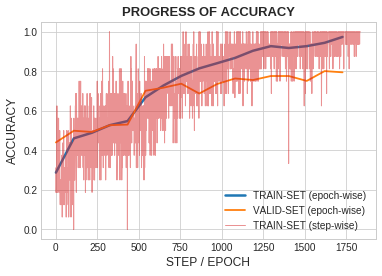

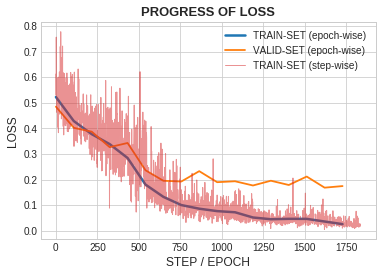



 +++ CONTINGENCY MATRIX +++
[[250.  69.   0.   0.]
 [189. 339.  29.   0.]
 [ 56.  69. 442.   0.]
 [  3.   0.   9. 475.]]


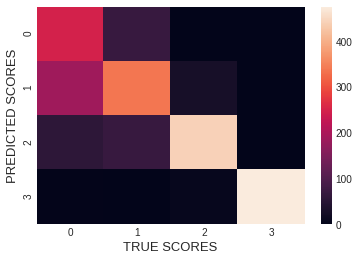


 > LOSS : 0.1813
 > ACCURACY : 0.7803
 > MEAN SQUARED ERR : 0.3192

 > MEAN PRECISION@20 : 50.00 %
 > MEAN RECALL@20 : 82.78 %
 > MEAN R PRECISION : 60.45 %
 > MEAN AVG. PRECISION : 69.39 %

 > MEAN NDCG (@100%) : 0.896743
 > (STD) DEV in NDCG (@100%) : 0.056296

 > MEAN NDCG (@20%) : 0.792602
 > (STD) DEV in NDCG (@20%) : 0.083132


In [50]:
baseline = 'bert_pp'
facet = 'background'
Implement(baseline, facet, train=True)


In [51]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : bert_pp <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using 

### [ METHOD ]


 > BASELINE : bert_pp
 > FACET : method

 EPOCH   1 | T.LOSS : 0.440142 | T.ACC : 0.388930 | V.LOSS : 0.421350 | V.ACC : 0.526264 | DUR : 2.0432
 EPOCH   2 | T.LOSS : 0.289350 | T.ACC : 0.555349 | V.LOSS : 0.270830 | V.ACC : 0.567889 | DUR : 2.0040
 EPOCH   3 | T.LOSS : 0.203694 | T.ACC : 0.628529 | V.LOSS : 0.198504 | V.ACC : 0.650149 | DUR : 2.0022
 EPOCH   4 | T.LOSS : 0.156873 | T.ACC : 0.670134 | V.LOSS : 0.177972 | V.ACC : 0.665015 | DUR : 1.8641
 EPOCH   5 | T.LOSS : 0.109067 | T.ACC : 0.758915 | V.LOSS : 0.178027 | V.ACC : 0.681863 | DUR : 1.9455
 EPOCH   6 | T.LOSS : 0.087854 | T.ACC : 0.809435 | V.LOSS : 0.162787 | V.ACC : 0.724480 | DUR : 2.0357
 EPOCH   7 | T.LOSS : 0.073253 | T.ACC : 0.850669 | V.LOSS : 0.170774 | V.ACC : 0.726462 | DUR : 2.0899
 EPOCH   8 | T.LOSS : 0.074637 | T.ACC : 0.845468 | V.LOSS : 0.148537 | V.ACC : 0.787909 | DUR : 1.9752
 EPOCH   9 | T.LOSS : 0.066361 | T.ACC : 0.865528 | V.LOSS : 0.146447 | V.ACC : 0.765114 | DUR : 1.9607
 EPOCH  10 | T.LOSS : 

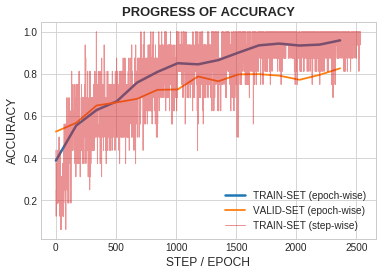

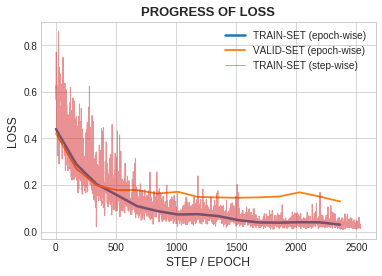



 +++ CONTINGENCY MATRIX +++
[[484. 103.   0.   0.]
 [241. 622.  11.   0.]
 [ 49.  12. 766.   0.]
 [  1.   0.   0. 742.]]


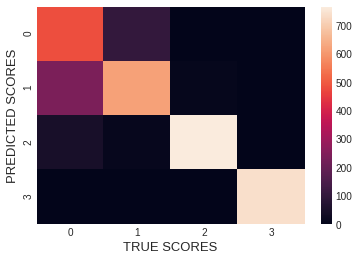


 > LOSS : 0.1067
 > ACCURACY : 0.8624
 > MEAN SQUARED ERR : 0.1887

 > MEAN PRECISION@20 : 32.65 %
 > MEAN RECALL@20 : 97.51 %
 > MEAN R PRECISION : 59.87 %
 > MEAN AVG. PRECISION : 77.90 %

 > MEAN NDCG (@100%) : 0.821562
 > (STD) DEV in NDCG (@100%) : 0.088182

 > MEAN NDCG (@20%) : 0.683535
 > (STD) DEV in NDCG (@20%) : 0.119936


In [52]:
baseline = 'bert_pp'
facet = 'method'
Implement(baseline, facet, train=True)


In [53]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : bert_pp <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subsequ

### [ RESULTS ]


 > BASELINE : bert_pp
 > FACET : result

 EPOCH   1 | T.LOSS : 0.643690 | T.ACC : 0.418693 | V.LOSS : 0.579916 | V.ACC : 0.454914 | DUR : 1.9123
 EPOCH   2 | T.LOSS : 0.500167 | T.ACC : 0.476444 | V.LOSS : 0.421076 | V.ACC : 0.508612 | DUR : 1.8830
 EPOCH   3 | T.LOSS : 0.365607 | T.ACC : 0.505319 | V.LOSS : 0.349130 | V.ACC : 0.493414 | DUR : 1.8658
 EPOCH   4 | T.LOSS : 0.252111 | T.ACC : 0.537994 | V.LOSS : 0.262247 | V.ACC : 0.541033 | DUR : 1.9215
 EPOCH   5 | T.LOSS : 0.199826 | T.ACC : 0.598024 | V.LOSS : 0.231008 | V.ACC : 0.582573 | DUR : 1.9021
 EPOCH   6 | T.LOSS : 0.172202 | T.ACC : 0.638678 | V.LOSS : 0.202668 | V.ACC : 0.649443 | DUR : 1.9141
 EPOCH   7 | T.LOSS : 0.139413 | T.ACC : 0.686170 | V.LOSS : 0.173256 | V.ACC : 0.663627 | DUR : 2.0081
 EPOCH   8 | T.LOSS : 0.121383 | T.ACC : 0.702888 | V.LOSS : 0.184115 | V.ACC : 0.631206 | DUR : 1.8571
 EPOCH   9 | T.LOSS : 0.098127 | T.ACC : 0.731383 | V.LOSS : 0.154195 | V.ACC : 0.672746 | DUR : 1.8323
 EPOCH  10 | T.LOSS : 

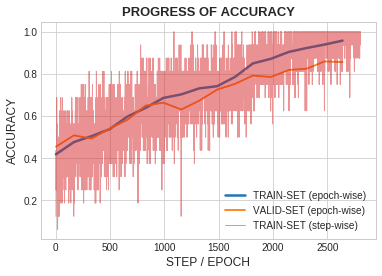

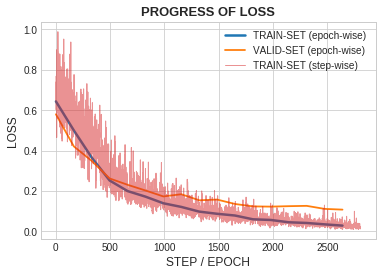



 +++ CONTINGENCY MATRIX +++
[[454.  94.   0.   0.]
 [205. 619.   4.   0.]
 [ 62.  36. 732.   0.]
 [  5.   8.   5. 737.]]


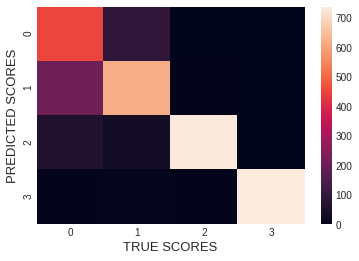


 > LOSS : 0.1165
 > ACCURACY : 0.8585
 > MEAN SQUARED ERR : 0.2259

 > MEAN PRECISION@20 : 42.35 %
 > MEAN RECALL@20 : 93.83 %
 > MEAN R PRECISION : 57.59 %
 > MEAN AVG. PRECISION : 76.68 %

 > MEAN NDCG (@100%) : 0.864336
 > (STD) DEV in NDCG (@100%) : 0.074354

 > MEAN NDCG (@20%) : 0.762573
 > (STD) DEV in NDCG (@20%) : 0.105729


In [54]:
baseline = 'bert_pp'
facet = 'result'
Implement(baseline, facet, train=True)


In [55]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : bert_pp <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 2156506 | GRADED RELEVANCE SCORE : 2.6577
 [ TITLE ] Mult

### [ AGGREGATED ]

In [39]:
baseline = 'bert_pp'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 86.02 %
 > (AGG) STD-DEV in NDCG (@100%) : 8.05 %
 > (AGG) MEAN NDCG (@20%) : 74.53 %
 > (AGG) STD-DEV in NDCG (@20%) : 11.41 %
 > (AGG) MEAN PRECISION@20 : 41.50 %
 > (AGG) MEAN RECALL@20 : 91.55 %
 > (AGG) MEAN R PRECISION : 59.28 %
 > (AGG) MEAN AVG. PRECISION : 74.76 %


## SciBERT Cased Baseline (scibert_cased)

### [ BACKGROUND ]


 > BASELINE : scibert_cased
 > FACET : background

 EPOCH   1 | T.LOSS : 1.859504 | T.ACC : 0.359767 | V.LOSS : 0.506330 | V.ACC : 0.447900 | DUR : 1.1500
 EPOCH   2 | T.LOSS : 0.426079 | T.ACC : 0.460641 | V.LOSS : 0.430232 | V.ACC : 0.480560 | DUR : 1.2549
 EPOCH   3 | T.LOSS : 0.376129 | T.ACC : 0.482216 | V.LOSS : 0.377028 | V.ACC : 0.474339 | DUR : 1.1434
 EPOCH   4 | T.LOSS : 0.421922 | T.ACC : 0.477551 | V.LOSS : 0.450205 | V.ACC : 0.488336 | DUR : 1.2584
 EPOCH   5 | T.LOSS : 0.331867 | T.ACC : 0.523032 | V.LOSS : 0.354580 | V.ACC : 0.479005 | DUR : 1.2463
 EPOCH   6 | T.LOSS : 0.342495 | T.ACC : 0.524198 | V.LOSS : 0.599705 | V.ACC : 0.367030 | DUR : 1.1230
 EPOCH   7 | T.LOSS : 0.315026 | T.ACC : 0.527114 | V.LOSS : 0.339202 | V.ACC : 0.474339 | DUR : 1.1585
 EPOCH   8 | T.LOSS : 0.262992 | T.ACC : 0.552770 | V.LOSS : 0.395691 | V.ACC : 0.466563 | DUR : 1.1849
 EPOCH   9 | T.LOSS : 0.263083 | T.ACC : 0.563265 | V.LOSS : 0.309974 | V.ACC : 0.534992 | DUR : 1.3781
 EPOCH  10 |

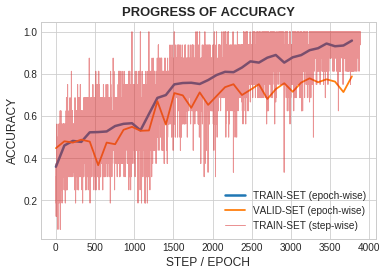

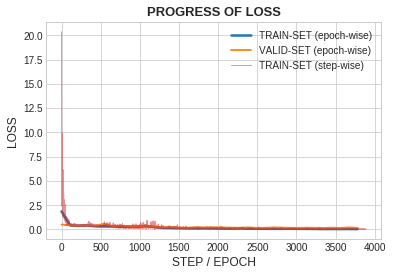



 +++ CONTINGENCY MATRIX +++
[[227.  77.   0.   0.]
 [187. 348.   7.   0.]
 [ 48.  65. 460.   1.]
 [  2.   1.  19. 488.]]


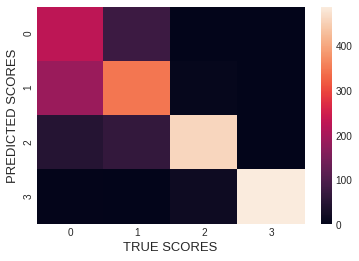


 > LOSS : 0.1590
 > ACCURACY : 0.7891
 > MEAN SQUARED ERR : 0.2953

 > MEAN PRECISION@20 : 51.56 %
 > MEAN RECALL@20 : 84.14 %
 > MEAN R PRECISION : 65.34 %
 > MEAN AVG. PRECISION : 69.84 %

 > MEAN NDCG (@100%) : 0.925495
 > (STD) DEV in NDCG (@100%) : 0.048495

 > MEAN NDCG (@20%) : 0.847865
 > (STD) DEV in NDCG (@20%) : 0.087954


In [57]:
baseline = 'scibert_cased'
facet = 'background'
Implement(baseline, facet, train=True)


In [58]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : scibert_cased <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to 

### [ METHOD ]


 > BASELINE : scibert_cased
 > FACET : method

 EPOCH   1 | T.LOSS : 1.254094 | T.ACC : 0.322065 | V.LOSS : 0.483956 | V.ACC : 0.292369 | DUR : 1.8343
 EPOCH   2 | T.LOSS : 0.436682 | T.ACC : 0.376300 | V.LOSS : 0.459071 | V.ACC : 0.340932 | DUR : 1.7955
 EPOCH   3 | T.LOSS : 0.402568 | T.ACC : 0.376300 | V.LOSS : 0.399586 | V.ACC : 0.399405 | DUR : 1.8309
 EPOCH   4 | T.LOSS : 1.000971 | T.ACC : 0.368499 | V.LOSS : 2.398665 | V.ACC : 0.341923 | DUR : 1.8373
 EPOCH   5 | T.LOSS : 2.747048 | T.ACC : 0.358098 | V.LOSS : 0.887295 | V.ACC : 0.473736 | DUR : 1.7141
 EPOCH   6 | T.LOSS : 0.353066 | T.ACC : 0.475111 | V.LOSS : 0.230647 | V.ACC : 0.484638 | DUR : 1.7810
 EPOCH   7 | T.LOSS : 0.179353 | T.ACC : 0.494056 | V.LOSS : 0.183053 | V.ACC : 0.486620 | DUR : 1.8078
 EPOCH   8 | T.LOSS : 0.137689 | T.ACC : 0.513744 | V.LOSS : 0.167734 | V.ACC : 0.496531 | DUR : 1.8218
 EPOCH   9 | T.LOSS : 0.116950 | T.ACC : 0.565750 | V.LOSS : 0.139178 | V.ACC : 0.612488 | DUR : 1.8052
 EPOCH  10 | T.L

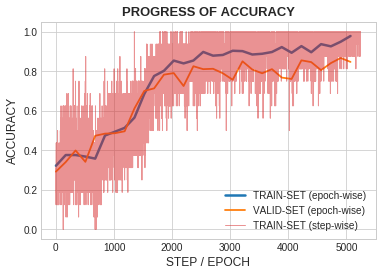

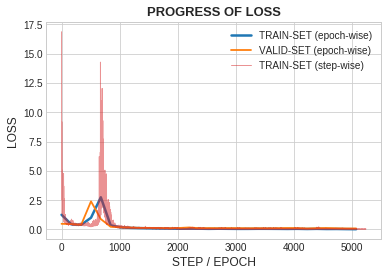



 +++ CONTINGENCY MATRIX +++
[[602. 238.   0.   0.]
 [153. 534.  90.   0.]
 [ 13.  11. 643.   0.]
 [  0.   0.   0. 747.]]


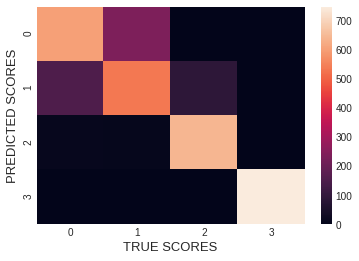


 > LOSS : 0.0900
 > ACCURACY : 0.8334
 > MEAN SQUARED ERR : 0.1795

 > MEAN PRECISION@20 : 33.82 %
 > MEAN RECALL@20 : 99.16 %
 > MEAN R PRECISION : 82.32 %
 > MEAN AVG. PRECISION : 77.20 %

 > MEAN NDCG (@100%) : 0.888436
 > (STD) DEV in NDCG (@100%) : 0.058887

 > MEAN NDCG (@20%) : 0.792426
 > (STD) DEV in NDCG (@20%) : 0.096295


In [59]:
baseline = 'scibert_cased'
facet = 'method'
Implement(baseline, facet, train=True)


In [60]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : scibert_cased <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is s

### [ RESULTS ]


 > BASELINE : scibert_cased
 > FACET : result

 EPOCH   1 | T.LOSS : 1.360180 | T.ACC : 0.380699 | V.LOSS : 0.724639 | V.ACC : 0.418440 | DUR : 1.6161
 EPOCH   2 | T.LOSS : 0.575983 | T.ACC : 0.448328 | V.LOSS : 0.407318 | V.ACC : 0.508612 | DUR : 1.7132
 EPOCH   3 | T.LOSS : 0.366568 | T.ACC : 0.503040 | V.LOSS : 0.321693 | V.ACC : 0.506586 | DUR : 1.6596
 EPOCH   4 | T.LOSS : 0.324525 | T.ACC : 0.548632 | V.LOSS : 0.322489 | V.ACC : 0.584600 | DUR : 1.6489
 EPOCH   5 | T.LOSS : 0.246040 | T.ACC : 0.616261 | V.LOSS : 0.250950 | V.ACC : 0.570415 | DUR : 1.6792
 EPOCH   6 | T.LOSS : 0.487436 | T.ACC : 0.528116 | V.LOSS : 1.484608 | V.ACC : 0.353597 | DUR : 1.7587
 EPOCH   7 | T.LOSS : 8.603848 | T.ACC : 0.369301 | V.LOSS : 1.048401 | V.ACC : 0.405268 | DUR : 1.6857
 EPOCH   8 | T.LOSS : 0.505920 | T.ACC : 0.505699 | V.LOSS : 0.409829 | V.ACC : 0.512665 | DUR : 1.6995
 EPOCH   9 | T.LOSS : 0.238789 | T.ACC : 0.670213 | V.LOSS : 0.221393 | V.ACC : 0.701114 | DUR : 1.6595
 EPOCH  10 | T.L

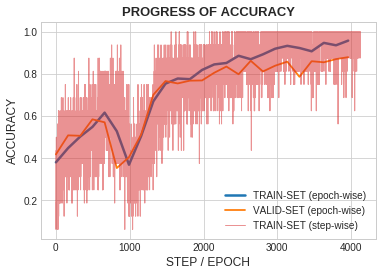

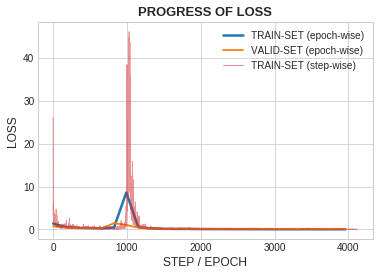



 +++ CONTINGENCY MATRIX +++
[[519. 110.   1.   0.]
 [181. 605.  12.   0.]
 [ 30.  24. 723.   0.]
 [  1.   0.   3. 752.]]


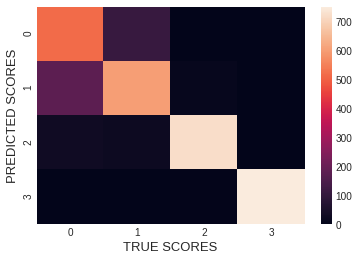


 > LOSS : 0.0907
 > ACCURACY : 0.8777
 > MEAN SQUARED ERR : 0.1564

 > MEAN PRECISION@20 : 45.00 %
 > MEAN RECALL@20 : 95.55 %
 > MEAN R PRECISION : 71.69 %
 > MEAN AVG. PRECISION : 77.22 %

 > MEAN NDCG (@100%) : 0.865559
 > (STD) DEV in NDCG (@100%) : 0.108233

 > MEAN NDCG (@20%) : 0.768953
 > (STD) DEV in NDCG (@20%) : 0.162719


In [61]:
baseline = 'scibert_cased'
facet = 'result'
Implement(baseline, facet, train=True)


In [62]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : scibert_cased <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 2156506 | GRADED RELEVANCE SCORE : 2.6394
 [ TITLE 

### [ AGGREGATED ]

In [40]:
baseline = 'scibert_cased'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 89.25 %
 > (AGG) STD-DEV in NDCG (@100%) : 8.07 %
 > (AGG) MEAN NDCG (@20%) : 80.22 %
 > (AGG) STD-DEV in NDCG (@20%) : 12.53 %
 > (AGG) MEAN PRECISION@20 : 43.30 %
 > (AGG) MEAN RECALL@20 : 93.13 %
 > (AGG) MEAN R PRECISION : 73.27 %
 > (AGG) MEAN AVG. PRECISION : 74.85 %


## SciBERT Uncased Baseline (scibert_uncased)

### [ BACKGROUND ]


 > BASELINE : scibert_uncased
 > FACET : background

 EPOCH   1 | T.LOSS : 1.621131 | T.ACC : 0.320117 | V.LOSS : 0.742537 | V.ACC : 0.415241 | DUR : 1.1050
 EPOCH   2 | T.LOSS : 0.776763 | T.ACC : 0.345773 | V.LOSS : 1.028382 | V.ACC : 0.314152 | DUR : 1.0736
 EPOCH   3 | T.LOSS : 0.471468 | T.ACC : 0.437318 | V.LOSS : 0.388910 | V.ACC : 0.471229 | DUR : 1.1182
 EPOCH   4 | T.LOSS : 0.387366 | T.ACC : 0.447230 | V.LOSS : 0.359980 | V.ACC : 0.477449 | DUR : 1.1121
 EPOCH   5 | T.LOSS : 0.341913 | T.ACC : 0.455977 | V.LOSS : 0.927537 | V.ACC : 0.318818 | DUR : 1.0660
 EPOCH   6 | T.LOSS : 0.414992 | T.ACC : 0.422157 | V.LOSS : 0.495956 | V.ACC : 0.443235 | DUR : 1.0569
 EPOCH   7 | T.LOSS : 0.604970 | T.ACC : 0.431487 | V.LOSS : 0.481073 | V.ACC : 0.382582 | DUR : 1.0656
 EPOCH   8 | T.LOSS : 0.377777 | T.ACC : 0.468805 | V.LOSS : 0.474402 | V.ACC : 0.458787 | DUR : 1.0951
 EPOCH   9 | T.LOSS : 0.235882 | T.ACC : 0.542857 | V.LOSS : 0.248863 | V.ACC : 0.505443 | DUR : 1.0864
 EPOCH  10

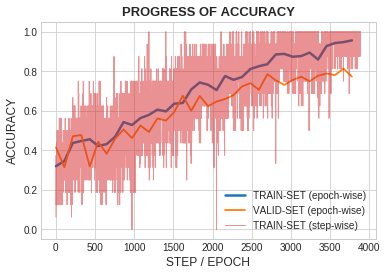

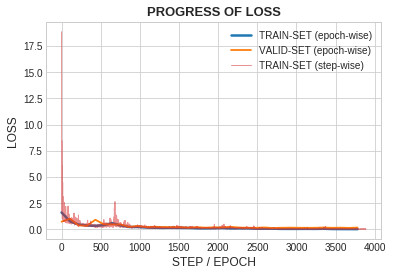



 +++ CONTINGENCY MATRIX +++
[[258.  66.   1.   0.]
 [146. 303.  42.   0.]
 [ 55.  93. 427.   0.]
 [ 10.   9.  23. 497.]]


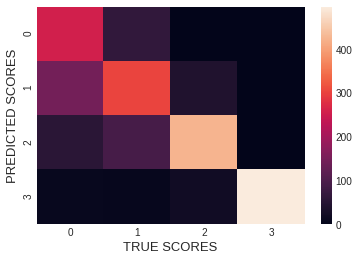


 > LOSS : 0.1936
 > ACCURACY : 0.7694
 > MEAN SQUARED ERR : 0.3731

 > MEAN PRECISION@20 : 46.25 %
 > MEAN RECALL@20 : 76.13 %
 > MEAN R PRECISION : 58.12 %
 > MEAN AVG. PRECISION : 67.21 %

 > MEAN NDCG (@100%) : 0.892186
 > (STD) DEV in NDCG (@100%) : 0.048088

 > MEAN NDCG (@20%) : 0.776912
 > (STD) DEV in NDCG (@20%) : 0.070267


In [64]:
baseline = 'scibert_uncased'
facet = 'background'
Implement(baseline, facet, train=True)


In [65]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : scibert_uncased <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language t

### [ METHOD ]


 > BASELINE : scibert_uncased
 > FACET : method

 EPOCH   1 | T.LOSS : 0.677815 | T.ACC : 0.284547 | V.LOSS : 0.511721 | V.ACC : 0.333994 | DUR : 1.8398
 EPOCH   2 | T.LOSS : 0.507382 | T.ACC : 0.331352 | V.LOSS : 0.521067 | V.ACC : 0.262636 | DUR : 1.8258
 EPOCH   3 | T.LOSS : 0.512988 | T.ACC : 0.326894 | V.LOSS : 0.443733 | V.ACC : 0.368682 | DUR : 1.7705
 EPOCH   4 | T.LOSS : 0.409534 | T.ACC : 0.440936 | V.LOSS : 0.327081 | V.ACC : 0.487612 | DUR : 2.1801
 EPOCH   5 | T.LOSS : 0.258361 | T.ACC : 0.539004 | V.LOSS : 0.262452 | V.ACC : 0.527255 | DUR : 1.7697
 EPOCH   6 | T.LOSS : 0.193358 | T.ACC : 0.570579 | V.LOSS : 0.230450 | V.ACC : 0.551041 | DUR : 1.7404
 EPOCH   7 | T.LOSS : 0.156835 | T.ACC : 0.579495 | V.LOSS : 0.160477 | V.ACC : 0.560951 | DUR : 1.7254
 EPOCH   8 | T.LOSS : 0.132802 | T.ACC : 0.602897 | V.LOSS : 0.178192 | V.ACC : 0.581764 | DUR : 1.8771
 EPOCH   9 | T.LOSS : 0.110292 | T.ACC : 0.654160 | V.LOSS : 0.161664 | V.ACC : 0.612488 | DUR : 1.8770
 EPOCH  10 | T

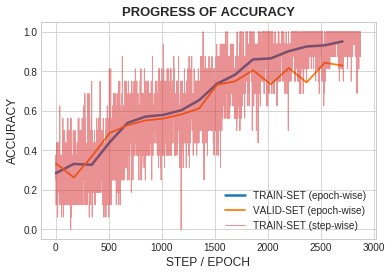

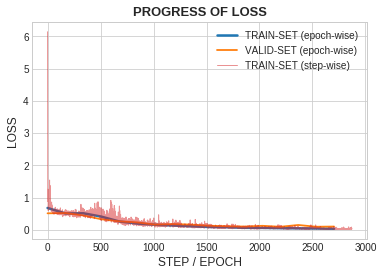



 +++ CONTINGENCY MATRIX +++
[[425. 135.   0.   0.]
 [292. 621. 113.   0.]
 [ 37.  20. 634.   0.]
 [  3.   0.  12. 739.]]


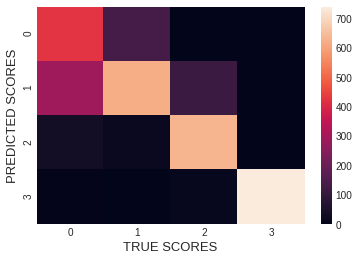


 > LOSS : 0.1201
 > ACCURACY : 0.7981
 > MEAN SQUARED ERR : 0.2465

 > MEAN PRECISION@20 : 31.47 %
 > MEAN RECALL@20 : 92.65 %
 > MEAN R PRECISION : 66.21 %
 > MEAN AVG. PRECISION : 77.27 %

 > MEAN NDCG (@100%) : 0.855711
 > (STD) DEV in NDCG (@100%) : 0.068256

 > MEAN NDCG (@20%) : 0.717938
 > (STD) DEV in NDCG (@20%) : 0.115929


In [66]:
baseline = 'scibert_uncased'
facet = 'method'
Implement(baseline, facet, train=True)


In [67]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : scibert_uncased <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is

### [ RESULTS ]


 > BASELINE : scibert_uncased
 > FACET : result

 EPOCH   1 | T.LOSS : 1.396731 | T.ACC : 0.271657 | V.LOSS : 0.685606 | V.ACC : 0.305978 | DUR : 1.6362
 EPOCH   2 | T.LOSS : 0.652018 | T.ACC : 0.311550 | V.LOSS : 0.593376 | V.ACC : 0.344478 | DUR : 1.6906
 EPOCH   3 | T.LOSS : 0.574606 | T.ACC : 0.328647 | V.LOSS : 0.537653 | V.ACC : 0.328267 | DUR : 1.6373
 EPOCH   4 | T.LOSS : 0.532828 | T.ACC : 0.333967 | V.LOSS : 0.508584 | V.ACC : 0.380952 | DUR : 1.7447
 EPOCH   5 | T.LOSS : 0.506520 | T.ACC : 0.324088 | V.LOSS : 0.533475 | V.ACC : 0.347518 | DUR : 1.6831
 EPOCH   6 | T.LOSS : 0.537877 | T.ACC : 0.413754 | V.LOSS : 0.572097 | V.ACC : 0.363728 | DUR : 1.6332
 EPOCH   7 | T.LOSS : 0.386273 | T.ACC : 0.460106 | V.LOSS : 0.345788 | V.ACC : 0.425532 | DUR : 1.6214
 EPOCH   8 | T.LOSS : 0.856350 | T.ACC : 0.412614 | V.LOSS : 1.403961 | V.ACC : 0.434650 | DUR : 1.6388
 EPOCH   9 | T.LOSS : 0.407205 | T.ACC : 0.511778 | V.LOSS : 0.203521 | V.ACC : 0.587639 | DUR : 1.6852
 EPOCH  10 | T

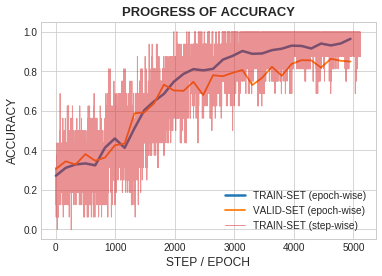

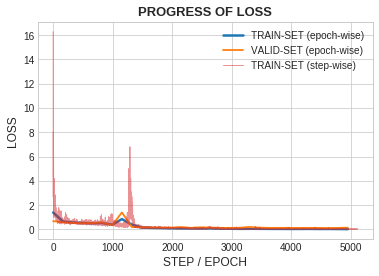



 +++ CONTINGENCY MATRIX +++
[[473.  43.   0.   0.]
 [239. 644.   7.   0.]
 [ 38.  32. 700.   0.]
 [  4.   1.  57. 723.]]


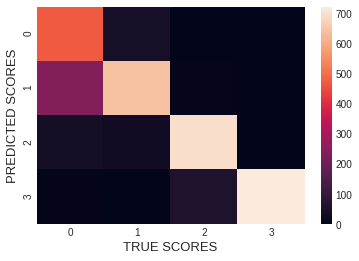


 > LOSS : 0.1125
 > ACCURACY : 0.8578
 > MEAN SQUARED ERR : 0.1925

 > MEAN PRECISION@20 : 44.41 %
 > MEAN RECALL@20 : 96.65 %
 > MEAN R PRECISION : 71.84 %
 > MEAN AVG. PRECISION : 77.38 %

 > MEAN NDCG (@100%) : 0.883438
 > (STD) DEV in NDCG (@100%) : 0.066338

 > MEAN NDCG (@20%) : 0.779804
 > (STD) DEV in NDCG (@20%) : 0.106909


In [68]:
baseline = 'scibert_uncased'
facet = 'result'
Implement(baseline, facet, train=True)


In [69]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : scibert_uncased <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 2156506 | GRADED RELEVANCE SCORE : 2.8437
 [ TITL

### [ AGGREGATED ]

In [41]:
baseline = 'scibert_uncased'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 87.68 %
 > (AGG) STD-DEV in NDCG (@100%) : 6.37 %
 > (AGG) MEAN NDCG (@20%) : 75.78 %
 > (AGG) STD-DEV in NDCG (@20%) : 10.42 %
 > (AGG) MEAN PRECISION@20 : 40.60 %
 > (AGG) MEAN RECALL@20 : 88.72 %
 > (AGG) MEAN R PRECISION : 65.54 %
 > (AGG) MEAN AVG. PRECISION : 74.09 %


## SPECTER Baseline (specter)

### [ BACKGROUND ]


 > BASELINE : specter
 > FACET : background

 EPOCH   1 | T.LOSS : 1.472495 | T.ACC : 0.321283 | V.LOSS : 0.706434 | V.ACC : 0.348367 | DUR : 1.0605
 EPOCH   2 | T.LOSS : 0.676161 | T.ACC : 0.342857 | V.LOSS : 0.617221 | V.ACC : 0.379471 | DUR : 1.0670
 EPOCH   3 | T.LOSS : 0.653872 | T.ACC : 0.365015 | V.LOSS : 0.963941 | V.ACC : 0.265941 | DUR : 1.0489
 EPOCH   4 | T.LOSS : 0.892123 | T.ACC : 0.338776 | V.LOSS : 0.959432 | V.ACC : 0.281493 | DUR : 1.0476
 EPOCH   5 | T.LOSS : 1.306906 | T.ACC : 0.328863 | V.LOSS : 0.561956 | V.ACC : 0.329705 | DUR : 1.0427
 EPOCH   6 | T.LOSS : 0.527240 | T.ACC : 0.393586 | V.LOSS : 0.520788 | V.ACC : 0.376361 | DUR : 1.1127
 EPOCH   7 | T.LOSS : 0.491487 | T.ACC : 0.485131 | V.LOSS : 0.496600 | V.ACC : 0.423017 | DUR : 1.0923
 EPOCH   8 | T.LOSS : 0.476457 | T.ACC : 0.507872 | V.LOSS : 0.504375 | V.ACC : 0.365474 | DUR : 1.0425
 EPOCH   9 | T.LOSS : 0.457350 | T.ACC : 0.562682 | V.LOSS : 0.479301 | V.ACC : 0.475894 | DUR : 1.0589
 EPOCH  10 | T.LOS

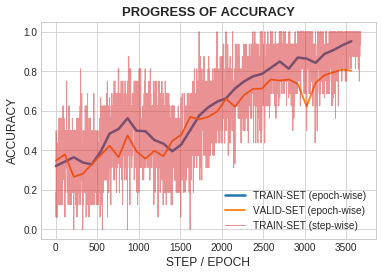

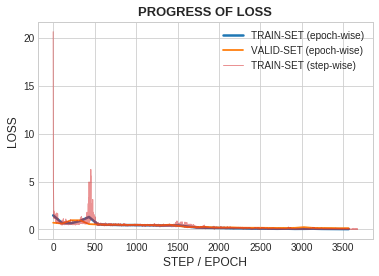



 +++ CONTINGENCY MATRIX +++
[[292. 101.   3.   0.]
 [148. 300.  30.   0.]
 [ 37.  69. 442.   0.]
 [  5.   6.   9. 488.]]


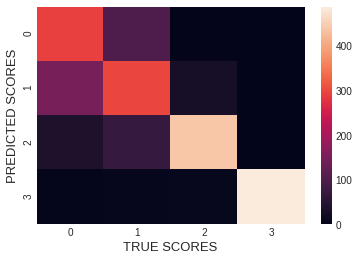


 > LOSS : 0.1536
 > ACCURACY : 0.7886
 > MEAN SQUARED ERR : 0.3036

 > MEAN PRECISION@20 : 50.94 %
 > MEAN RECALL@20 : 82.50 %
 > MEAN R PRECISION : 64.82 %
 > MEAN AVG. PRECISION : 67.63 %

 > MEAN NDCG (@100%) : 0.891271
 > (STD) DEV in NDCG (@100%) : 0.077335

 > MEAN NDCG (@20%) : 0.798697
 > (STD) DEV in NDCG (@20%) : 0.100953


In [71]:
baseline = 'specter'
facet = 'background'
Implement(baseline, facet, train=True) train=True)


In [72]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : specter <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using 

### [ METHOD ]


 > BASELINE : specter
 > FACET : method

 EPOCH   1 | T.LOSS : 1.126939 | T.ACC : 0.416048 | V.LOSS : 0.495532 | V.ACC : 0.473736 | DUR : 1.6802
 EPOCH   2 | T.LOSS : 0.418754 | T.ACC : 0.478826 | V.LOSS : 0.385894 | V.ACC : 0.487612 | DUR : 1.8479
 EPOCH   3 | T.LOSS : 0.395181 | T.ACC : 0.460996 | V.LOSS : 0.473755 | V.ACC : 0.434093 | DUR : 1.6985
 EPOCH   4 | T.LOSS : 0.612172 | T.ACC : 0.435364 | V.LOSS : 0.459022 | V.ACC : 0.470763 | DUR : 1.7847
 EPOCH   5 | T.LOSS : 0.342400 | T.ACC : 0.512630 | V.LOSS : 0.402574 | V.ACC : 0.493558 | DUR : 1.7670
 EPOCH   6 | T.LOSS : 0.192368 | T.ACC : 0.579866 | V.LOSS : 0.195418 | V.ACC : 0.549058 | DUR : 1.7409
 EPOCH   7 | T.LOSS : 0.160290 | T.ACC : 0.635958 | V.LOSS : 0.202553 | V.ACC : 0.597621 | DUR : 1.7258
 EPOCH   8 | T.LOSS : 0.151278 | T.ACC : 0.657875 | V.LOSS : 0.182918 | V.ACC : 0.629336 | DUR : 1.7096
 EPOCH   9 | T.LOSS : 0.128080 | T.ACC : 0.700966 | V.LOSS : 0.156633 | V.ACC : 0.671952 | DUR : 1.6725
 EPOCH  10 | T.LOSS : 

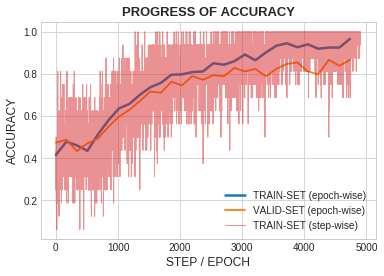

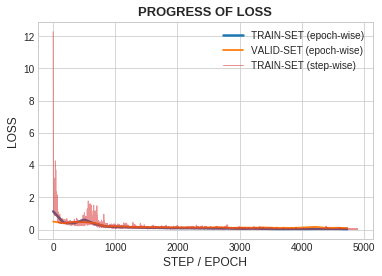



 +++ CONTINGENCY MATRIX +++
[[552. 192.   0.   0.]
 [179. 591.  13.   0.]
 [ 19.   9. 732.   0.]
 [  0.   0.   0. 744.]]


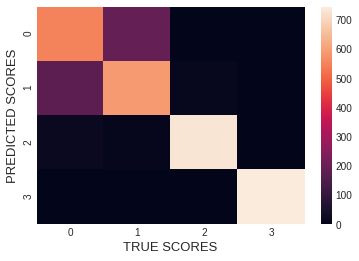


 > LOSS : 0.0889
 > ACCURACY : 0.8641
 > MEAN SQUARED ERR : 0.1547

 > MEAN PRECISION@20 : 33.82 %
 > MEAN RECALL@20 : 99.58 %
 > MEAN R PRECISION : 84.07 %
 > MEAN AVG. PRECISION : 76.08 %

 > MEAN NDCG (@100%) : 0.904864
 > (STD) DEV in NDCG (@100%) : 0.049277

 > MEAN NDCG (@20%) : 0.814325
 > (STD) DEV in NDCG (@20%) : 0.087219


In [73]:
baseline = 'specter'
facet = 'method'
Implement(baseline, facet, train=True)


In [74]:
QBERetrieveSciArticles(baseline, facet, '10010426')



 >>> BASELINE : specter <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] And That's A Fact: Distinguishing Factual and Emotional Argumentation in Online Dialogue
 [ ABSTRACT ] 
 We investigate the characteristics of factual and emotional argumentation styles observed in online debates.
 Using an annotated set of"factual"and"feeling"debate forum posts, we extract patterns that are highly correlated with factual and emotional arguments, and then apply a bootstrapping methodology to find new patterns in a larger pool of unannotated forum posts.
 This process automatically produces a large set of patterns representing linguistic expressions that are highly correlated with factual and emotional language.
 Finally, we analyze the most discriminating patterns to better understand the defining characteristics of factual and emotional arguments.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 6541910 | GRADED RELEVANCE SCORE : 2.5062
 [ TITLE ] Learning Extraction Patterns For S

### [ RESULTS ]


 > BASELINE : specter
 > FACET : result

 EPOCH   1 | T.LOSS : 1.744695 | T.ACC : 0.408435 | V.LOSS : 1.064772 | V.ACC : 0.353597 | DUR : 1.6479
 EPOCH   2 | T.LOSS : 0.634228 | T.ACC : 0.490881 | V.LOSS : 0.662492 | V.ACC : 0.377913 | DUR : 1.7507
 EPOCH   3 | T.LOSS : 0.524603 | T.ACC : 0.508359 | V.LOSS : 0.498170 | V.ACC : 0.370821 | DUR : 1.7031
 EPOCH   4 | T.LOSS : 0.365682 | T.ACC : 0.576368 | V.LOSS : 0.363293 | V.ACC : 0.559271 | DUR : 1.6203
 EPOCH   5 | T.LOSS : 0.253508 | T.ACC : 0.609802 | V.LOSS : 0.228005 | V.ACC : 0.639311 | DUR : 1.6551
 EPOCH   6 | T.LOSS : 0.184144 | T.ACC : 0.680851 | V.LOSS : 0.220284 | V.ACC : 0.660588 | DUR : 1.6533
 EPOCH   7 | T.LOSS : 0.154023 | T.ACC : 0.702128 | V.LOSS : 0.174201 | V.ACC : 0.683891 | DUR : 1.6159
 EPOCH   8 | T.LOSS : 0.166194 | T.ACC : 0.690729 | V.LOSS : 0.192353 | V.ACC : 0.659574 | DUR : 1.6448
 EPOCH   9 | T.LOSS : 0.157123 | T.ACC : 0.704027 | V.LOSS : 0.186983 | V.ACC : 0.688956 | DUR : 1.6079
 EPOCH  10 | T.LOSS : 

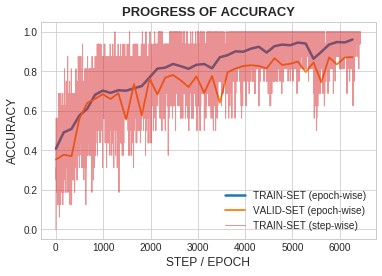

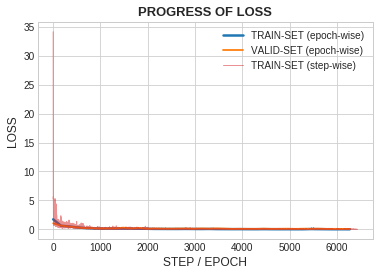



 +++ CONTINGENCY MATRIX +++
[[522. 101.   0.   0.]
 [184. 615.  21.   0.]
 [ 23.  21. 716.   0.]
 [  0.   0.   0. 758.]]


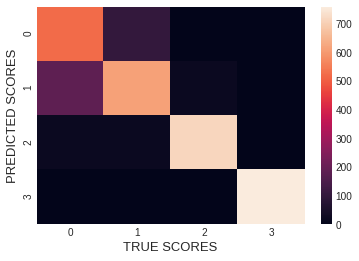


 > LOSS : 0.0788
 > ACCURACY : 0.8818
 > MEAN SQUARED ERR : 0.1415

 > MEAN PRECISION@20 : 45.88 %
 > MEAN RECALL@20 : 98.20 %
 > MEAN R PRECISION : 78.22 %
 > MEAN AVG. PRECISION : 75.91 %

 > MEAN NDCG (@100%) : 0.927467
 > (STD) DEV in NDCG (@100%) : 0.031320

 > MEAN NDCG (@20%) : 0.845796
 > (STD) DEV in NDCG (@20%) : 0.062399


In [75]:
baseline = 'specter'
facet = 'result'
Implement(baseline, facet, train=True)


In [76]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : specter <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 1518169 | GRADED RELEVANCE SCORE : 2.7466
 [ TITLE ] Lear

### [ AGGREGATED ]

In [42]:
baseline = 'specter'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 90.82 %
 > (AGG) STD-DEV in NDCG (@100%) : 5.74 %
 > (AGG) MEAN NDCG (@20%) : 82.00 %
 > (AGG) STD-DEV in NDCG (@20%) : 8.69 %
 > (AGG) MEAN PRECISION@20 : 43.40 %
 > (AGG) MEAN RECALL@20 : 93.65 %
 > (AGG) MEAN R PRECISION : 75.92 %
 > (AGG) MEAN AVG. PRECISION : 73.32 %


## SimCSE Baseline (simcse)

### [ BACKGROUND ]


 > BASELINE : susimcse
 > FACET : background

 EPOCH   1 | T.LOSS : 0.501781 | T.ACC : 0.317784 | V.LOSS : 0.483825 | V.ACC : 0.410575 | DUR : 1.0148
 EPOCH   2 | T.LOSS : 0.472728 | T.ACC : 0.397085 | V.LOSS : 0.485311 | V.ACC : 0.399689 | DUR : 1.0711
 EPOCH   3 | T.LOSS : 0.460510 | T.ACC : 0.422157 | V.LOSS : 0.457539 | V.ACC : 0.443235 | DUR : 1.0595
 EPOCH   4 | T.LOSS : 0.440878 | T.ACC : 0.483965 | V.LOSS : 0.477072 | V.ACC : 0.483670 | DUR : 1.0287
 EPOCH   5 | T.LOSS : 0.434929 | T.ACC : 0.499125 | V.LOSS : 0.460597 | V.ACC : 0.488336 | DUR : 1.0458
 EPOCH   6 | T.LOSS : 0.429573 | T.ACC : 0.511370 | V.LOSS : 0.457267 | V.ACC : 0.489891 | DUR : 1.0325
 EPOCH   7 | T.LOSS : 0.416318 | T.ACC : 0.542857 | V.LOSS : 0.450005 | V.ACC : 0.466563 | DUR : 1.0087
 EPOCH   8 | T.LOSS : 0.406490 | T.ACC : 0.539359 | V.LOSS : 0.416015 | V.ACC : 0.505443 | DUR : 1.0373
 EPOCH   9 | T.LOSS : 0.392741 | T.ACC : 0.552187 | V.LOSS : 0.408791 | V.ACC : 0.489891 | DUR : 1.0057
 EPOCH  10 | T.LO

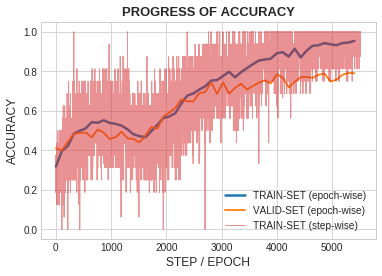

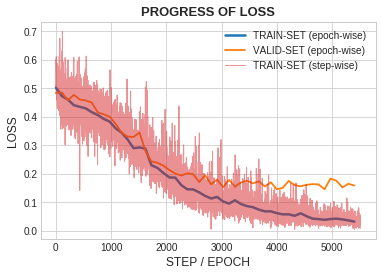



 +++ CONTINGENCY MATRIX +++
[[261. 114.   3.   0.]
 [166. 280.  38.   0.]
 [ 61.  71. 424.   7.]
 [  9.   2.  15. 479.]]


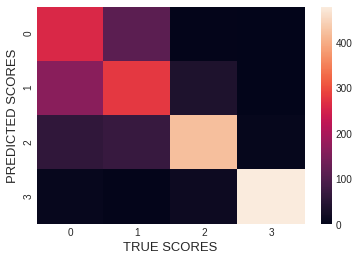


 > LOSS : 0.2048
 > ACCURACY : 0.7482
 > MEAN SQUARED ERR : 0.3917

 > MEAN PRECISION@20 : 48.44 %
 > MEAN RECALL@20 : 77.43 %
 > MEAN R PRECISION : 62.06 %
 > MEAN AVG. PRECISION : 70.39 %

 > MEAN NDCG (@100%) : 0.880539
 > (STD) DEV in NDCG (@100%) : 0.078289

 > MEAN NDCG (@20%) : 0.768081
 > (STD) DEV in NDCG (@20%) : 0.124106


In [78]:
baseline = 'susimcse'
facet = 'background'
Implement(baseline, facet, train=True)


In [79]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : susimcse <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using

### [ METHOD ]


 > BASELINE : susimcse
 > FACET : method

 EPOCH   1 | T.LOSS : 0.502859 | T.ACC : 0.299777 | V.LOSS : 0.426868 | V.ACC : 0.470763 | DUR : 1.5525
 EPOCH   2 | T.LOSS : 0.321801 | T.ACC : 0.519316 | V.LOSS : 0.289894 | V.ACC : 0.570862 | DUR : 1.5948
 EPOCH   3 | T.LOSS : 0.264283 | T.ACC : 0.569094 | V.LOSS : 0.263069 | V.ACC : 0.576809 | DUR : 1.5194
 EPOCH   4 | T.LOSS : 0.231440 | T.ACC : 0.612556 | V.LOSS : 0.333111 | V.ACC : 0.488603 | DUR : 1.5894
 EPOCH   5 | T.LOSS : 0.201716 | T.ACC : 0.635215 | V.LOSS : 0.212940 | V.ACC : 0.656095 | DUR : 1.6150
 EPOCH   6 | T.LOSS : 0.174879 | T.ACC : 0.660104 | V.LOSS : 0.232438 | V.ACC : 0.600595 | DUR : 1.5634
 EPOCH   7 | T.LOSS : 0.163084 | T.ACC : 0.680163 | V.LOSS : 0.214920 | V.ACC : 0.637265 | DUR : 1.5793
 EPOCH   8 | T.LOSS : 0.147519 | T.ACC : 0.695022 | V.LOSS : 0.192245 | V.ACC : 0.669970 | DUR : 1.5883
 EPOCH   9 | T.LOSS : 0.133881 | T.ACC : 0.722883 | V.LOSS : 0.236637 | V.ACC : 0.590684 | DUR : 1.5809
 EPOCH  10 | T.LOSS :

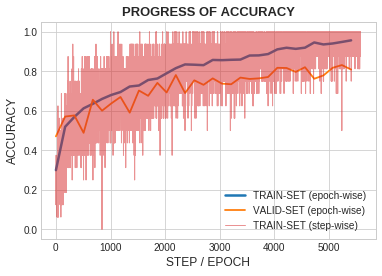

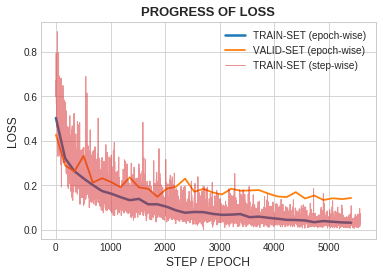



 +++ CONTINGENCY MATRIX +++
[[516. 191.   0.   0.]
 [186. 544.  28.   0.]
 [ 51.  17. 717.   0.]
 [ 11.   0.  19. 751.]]


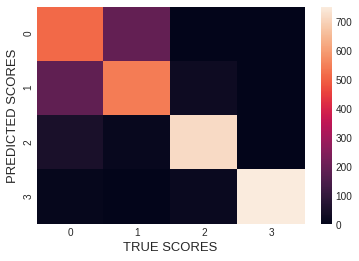


 > LOSS : 0.1347
 > ACCURACY : 0.8340
 > MEAN SQUARED ERR : 0.2455

 > MEAN PRECISION@20 : 31.76 %
 > MEAN RECALL@20 : 95.20 %
 > MEAN R PRECISION : 55.25 %
 > MEAN AVG. PRECISION : 79.11 %

 > MEAN NDCG (@100%) : 0.790508
 > (STD) DEV in NDCG (@100%) : 0.074935

 > MEAN NDCG (@20%) : 0.655642
 > (STD) DEV in NDCG (@20%) : 0.105526


In [80]:
baseline = 'susimcse'
facet = 'method'
Implement(baseline, facet, train=True)


In [81]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : susimcse <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subseq

### [ RESULTS ]


 > BASELINE : susimcse
 > FACET : result

 EPOCH   1 | T.LOSS : 0.564191 | T.ACC : 0.358283 | V.LOSS : 0.526512 | V.ACC : 0.402229 | DUR : 1.6210
 EPOCH   2 | T.LOSS : 0.488295 | T.ACC : 0.470365 | V.LOSS : 0.470929 | V.ACC : 0.464032 | DUR : 1.6620
 EPOCH   3 | T.LOSS : 0.439386 | T.ACC : 0.505319 | V.LOSS : 0.429467 | V.ACC : 0.526849 | DUR : 1.5922
 EPOCH   4 | T.LOSS : 0.388782 | T.ACC : 0.553951 | V.LOSS : 0.388429 | V.ACC : 0.542047 | DUR : 1.6990
 EPOCH   5 | T.LOSS : 0.323983 | T.ACC : 0.564590 | V.LOSS : 0.295966 | V.ACC : 0.572442 | DUR : 1.6202
 EPOCH   6 | T.LOSS : 0.267260 | T.ACC : 0.580167 | V.LOSS : 0.236546 | V.ACC : 0.620061 | DUR : 1.6441
 EPOCH   7 | T.LOSS : 0.211837 | T.ACC : 0.617781 | V.LOSS : 0.215516 | V.ACC : 0.605876 | DUR : 1.6086
 EPOCH   8 | T.LOSS : 0.180059 | T.ACC : 0.663754 | V.LOSS : 0.179636 | V.ACC : 0.679838 | DUR : 1.6029
 EPOCH   9 | T.LOSS : 0.160291 | T.ACC : 0.674392 | V.LOSS : 0.171933 | V.ACC : 0.706180 | DUR : 1.6562
 EPOCH  10 | T.LOSS :

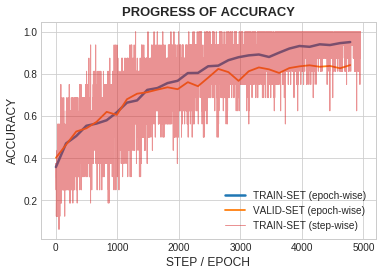

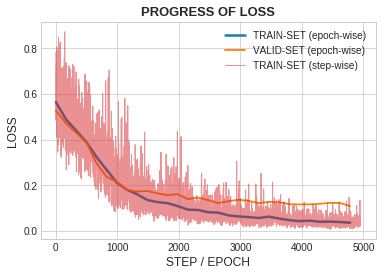



 +++ CONTINGENCY MATRIX +++
[[522. 182.   0.   0.]
 [203. 528.  37.   0.]
 [ 46.  27. 674.   0.]
 [  4.   1.  12. 725.]]


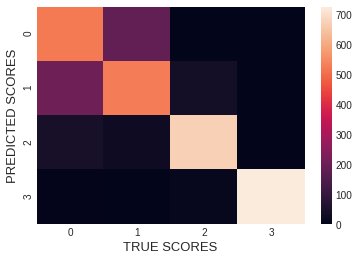


 > LOSS : 0.1200
 > ACCURACY : 0.8271
 > MEAN SQUARED ERR : 0.2313

 > MEAN PRECISION@20 : 42.94 %
 > MEAN RECALL@20 : 93.54 %
 > MEAN R PRECISION : 68.82 %
 > MEAN AVG. PRECISION : 77.43 %

 > MEAN NDCG (@100%) : 0.875979
 > (STD) DEV in NDCG (@100%) : 0.074063

 > MEAN NDCG (@20%) : 0.765212
 > (STD) DEV in NDCG (@20%) : 0.115561


In [82]:
baseline = 'susimcse'
facet = 'result'
Implement(baseline, facet, train=True)


In [83]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : susimcse <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 1518169 | GRADED RELEVANCE SCORE : 2.6857
 [ TITLE ] Lea

### [ AGGREGATED ]

In [43]:
baseline = 'susimcse'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 84.84 %
 > (AGG) STD-DEV in NDCG (@100%) : 8.64 %
 > (AGG) MEAN NDCG (@20%) : 72.89 %
 > (AGG) STD-DEV in NDCG (@20%) : 12.66 %
 > (AGG) MEAN PRECISION@20 : 40.90 %
 > (AGG) MEAN RECALL@20 : 88.95 %
 > (AGG) MEAN R PRECISION : 62.05 %
 > (AGG) MEAN AVG. PRECISION : 75.75 %


## UnSimCSE Baseline (unsimcse)

### [ BACKGROUND ]


 > BASELINE : unsimcse
 > FACET : background

 EPOCH   1 | T.LOSS : 0.709891 | T.ACC : 0.281633 | V.LOSS : 0.643546 | V.ACC : 0.328149 | DUR : 1.0311
 EPOCH   2 | T.LOSS : 0.605127 | T.ACC : 0.372012 | V.LOSS : 0.562751 | V.ACC : 0.376361 | DUR : 1.0790
 EPOCH   3 | T.LOSS : 0.552764 | T.ACC : 0.413411 | V.LOSS : 0.510889 | V.ACC : 0.426128 | DUR : 1.0523
 EPOCH   4 | T.LOSS : 0.514148 | T.ACC : 0.471137 | V.LOSS : 0.495839 | V.ACC : 0.415241 | DUR : 1.0883
 EPOCH   5 | T.LOSS : 0.473704 | T.ACC : 0.478134 | V.LOSS : 0.446420 | V.ACC : 0.433904 | DUR : 1.0544
 EPOCH   6 | T.LOSS : 0.416809 | T.ACC : 0.471137 | V.LOSS : 0.398209 | V.ACC : 0.471229 | DUR : 1.0754
 EPOCH   7 | T.LOSS : 0.369571 | T.ACC : 0.460058 | V.LOSS : 0.357087 | V.ACC : 0.475894 | DUR : 1.0631
 EPOCH   8 | T.LOSS : 0.347061 | T.ACC : 0.505539 | V.LOSS : 0.442585 | V.ACC : 0.468118 | DUR : 1.0929
 EPOCH   9 | T.LOSS : 0.320475 | T.ACC : 0.507872 | V.LOSS : 0.309752 | V.ACC : 0.477449 | DUR : 1.0631
 EPOCH  10 | T.LO

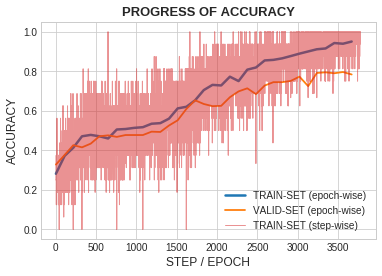

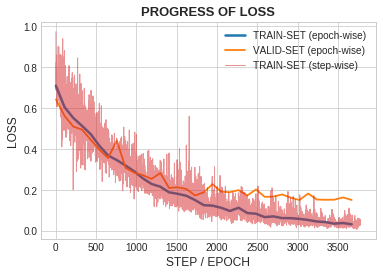



 +++ CONTINGENCY MATRIX +++
[[289. 120.   0.   0.]
 [135. 286.  27.   0.]
 [ 38.  76. 446.   0.]
 [  7.   5.  10. 491.]]


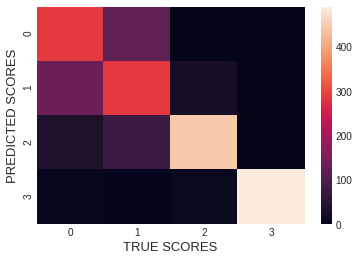


 > LOSS : 0.1610
 > ACCURACY : 0.7834
 > MEAN SQUARED ERR : 0.3124

 > MEAN PRECISION@20 : 48.12 %
 > MEAN RECALL@20 : 80.15 %
 > MEAN R PRECISION : 61.61 %
 > MEAN AVG. PRECISION : 68.55 %

 > MEAN NDCG (@100%) : 0.893350
 > (STD) DEV in NDCG (@100%) : 0.064366

 > MEAN NDCG (@20%) : 0.802450
 > (STD) DEV in NDCG (@20%) : 0.090347


In [85]:
baseline = 'unsimcse'
facet = 'background'
Implement(baseline, facet, train=True)


In [86]:
QBERetrieveSciArticles(baseline, facet, '1791179')



 >>> BASELINE : unsimcse <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] A Sequential Model for Multi-Class Classification
 [ ABSTRACT ] 
 Many classification problems require decisions among a large number of competing classes.
 These tasks, however, are not handled well by general purpose learning methods and are usually addressed in an ad-hoc fashion.
 We suggest a general approach -- a sequential learning model that utilizes classifiers to sequentially restrict the number of competing classes while maintaining, with high probability, the presence of the true outcome in the candidates set.
 Some theoretical and computational properties of the model are discussed and we argue that these are important in NLP-like domains.
 The advantages of the model are illustrated in an experiment in part-of-speech tagging.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 63643710 | GRADED RELEVANCE SCORE : 2.7511
 [ TITLE ] Multiclass Classification Through Multidimensional Clus

### [ METHOD ]


 > BASELINE : unsimcse
 > FACET : method

 EPOCH   1 | T.LOSS : 0.638152 | T.ACC : 0.258915 | V.LOSS : 0.614571 | V.ACC : 0.263627 | DUR : 1.6434
 EPOCH   2 | T.LOSS : 0.510128 | T.ACC : 0.331724 | V.LOSS : 0.429910 | V.ACC : 0.391477 | DUR : 1.6405
 EPOCH   3 | T.LOSS : 0.374059 | T.ACC : 0.366642 | V.LOSS : 0.325798 | V.ACC : 0.305253 | DUR : 1.7491
 EPOCH   4 | T.LOSS : 0.267179 | T.ACC : 0.481426 | V.LOSS : 0.248034 | V.ACC : 0.560951 | DUR : 1.6530
 EPOCH   5 | T.LOSS : 0.212915 | T.ACC : 0.605869 | V.LOSS : 0.224966 | V.ACC : 0.577800 | DUR : 1.6792
 EPOCH   6 | T.LOSS : 0.172315 | T.ACC : 0.648588 | V.LOSS : 0.184590 | V.ACC : 0.672944 | DUR : 1.7314
 EPOCH   7 | T.LOSS : 0.158938 | T.ACC : 0.678678 | V.LOSS : 0.200189 | V.ACC : 0.655104 | DUR : 1.6751
 EPOCH   8 | T.LOSS : 0.139450 | T.ACC : 0.723254 | V.LOSS : 0.171979 | V.ACC : 0.693756 | DUR : 1.6824
 EPOCH   9 | T.LOSS : 0.129294 | T.ACC : 0.735884 | V.LOSS : 0.169001 | V.ACC : 0.707631 | DUR : 1.7507
 EPOCH  10 | T.LOSS :

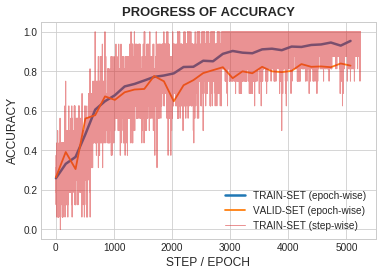

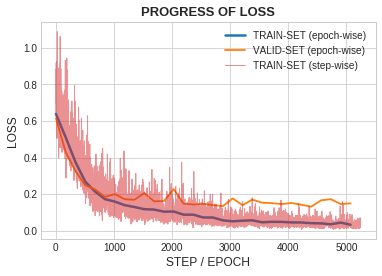



 +++ CONTINGENCY MATRIX +++
[[447. 148.   0.   0.]
 [225. 583.  22.   0.]
 [ 61.  31. 701.   0.]
 [  8.   1.   7. 797.]]


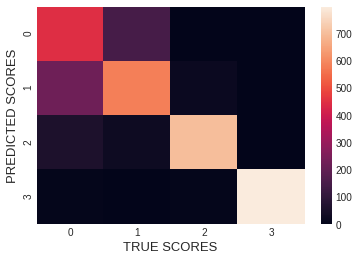


 > LOSS : 0.1406
 > ACCURACY : 0.8340
 > MEAN SQUARED ERR : 0.2484

 > MEAN PRECISION@20 : 31.18 %
 > MEAN RECALL@20 : 94.47 %
 > MEAN R PRECISION : 56.37 %
 > MEAN AVG. PRECISION : 79.11 %

 > MEAN NDCG (@100%) : 0.792931
 > (STD) DEV in NDCG (@100%) : 0.080292

 > MEAN NDCG (@20%) : 0.631998
 > (STD) DEV in NDCG (@20%) : 0.132717


In [87]:
baseline = 'unsimcse'
facet = 'method'
Implement(baseline, facet, train=True)


In [88]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : unsimcse <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subseq

### [ RESULTS ]


 > BASELINE : unsimcse
 > FACET : result

 EPOCH   1 | T.LOSS : 0.521088 | T.ACC : 0.324848 | V.LOSS : 0.522033 | V.ACC : 0.352584 | DUR : 1.6771
 EPOCH   2 | T.LOSS : 0.390182 | T.ACC : 0.470745 | V.LOSS : 0.338419 | V.ACC : 0.487335 | DUR : 1.6625
 EPOCH   3 | T.LOSS : 0.309149 | T.ACC : 0.532675 | V.LOSS : 0.261280 | V.ACC : 0.495441 | DUR : 1.6561
 EPOCH   4 | T.LOSS : 0.255121 | T.ACC : 0.550532 | V.LOSS : 0.224172 | V.ACC : 0.553191 | DUR : 1.6571
 EPOCH   5 | T.LOSS : 0.210860 | T.ACC : 0.615502 | V.LOSS : 0.218999 | V.ACC : 0.599797 | DUR : 1.6493
 EPOCH   6 | T.LOSS : 0.175546 | T.ACC : 0.653875 | V.LOSS : 0.215014 | V.ACC : 0.596758 | DUR : 1.6947
 EPOCH   7 | T.LOSS : 0.148953 | T.ACC : 0.676672 | V.LOSS : 0.151722 | V.ACC : 0.658561 | DUR : 1.6140
 EPOCH   8 | T.LOSS : 0.137880 | T.ACC : 0.694149 | V.LOSS : 0.131586 | V.ACC : 0.720365 | DUR : 1.6445
 EPOCH   9 | T.LOSS : 0.119432 | T.ACC : 0.730623 | V.LOSS : 0.142149 | V.ACC : 0.742655 | DUR : 1.6732
 EPOCH  10 | T.LOSS :

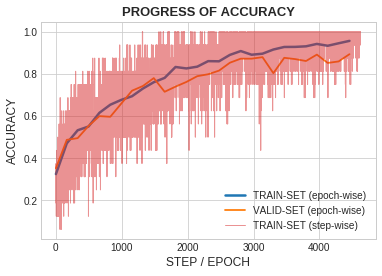

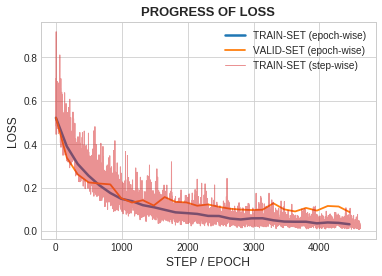



 +++ CONTINGENCY MATRIX +++
[[507. 131.   0.   0.]
 [204. 609.  13.   0.]
 [ 49.  26. 685.   0.]
 [  4.   3.  10. 720.]]


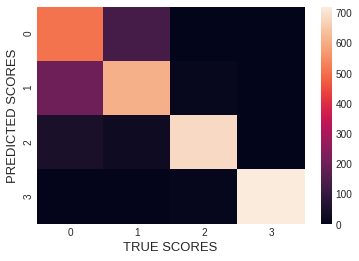


 > LOSS : 0.1151
 > ACCURACY : 0.8514
 > MEAN SQUARED ERR : 0.2121

 > MEAN PRECISION@20 : 44.12 %
 > MEAN RECALL@20 : 94.31 %
 > MEAN R PRECISION : 71.49 %
 > MEAN AVG. PRECISION : 77.32 %

 > MEAN NDCG (@100%) : 0.881944
 > (STD) DEV in NDCG (@100%) : 0.061734

 > MEAN NDCG (@20%) : 0.779792
 > (STD) DEV in NDCG (@20%) : 0.106544


In [89]:
baseline = 'unsimcse'
facet = 'result'
Implement(baseline, facet, train=True)


In [90]:
QBERetrieveSciArticles(baseline, facet, '5052952')



 >>> BASELINE : unsimcse <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Veracity Computing from Lexical Cues and Perceived Certainty Trends
 [ ABSTRACT ] 
 We present a data-driven method for determining the veracity of a set of rumorous claims on social media data.
 Tweets from different sources pertaining to a rumor are processed on three levels: first, factuality values are assigned to each tweet based on four textual cue categories relevant for our journalism use case; these amalgamate speaker support in terms of polarity and commitment in terms of certainty and speculation.
 Next, the proportions of these lexical cues are utilized as predictors for tweet certainty in a generalized linear regression model.
 Subsequently, lexical cue proportions, predicted certainty, as well as their time course characteristics are used to compute veracity for each rumor in terms of the identity of the rumor-resolving tweet and its binary resolution value judgment.
 The system operat

### [ AGGREGATED ]

In [44]:
baseline = 'unsimcse'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 85.53 %
 > (AGG) STD-DEV in NDCG (@100%) : 8.27 %
 > (AGG) MEAN NDCG (@20%) : 73.68 %
 > (AGG) STD-DEV in NDCG (@20%) : 13.49 %
 > (AGG) MEAN PRECISION@20 : 41.00 %
 > (AGG) MEAN RECALL@20 : 89.83 %
 > (AGG) MEAN R PRECISION : 63.19 %
 > (AGG) MEAN AVG. PRECISION : 75.12 %


## ENSEMBLE CONSTRUCTION

###### The following table contains the %-NDCG values (for 100% data, unless explicitly mentioned otherwise) for all baseline-facet pairs and also for the aggregated pool of queries.

| <i>FACET / BASELINE</i> | BERT_NLI | BERT_PP | SCIBERT_CASED | SCIBERT_UNCASED | SPECTER | SUSIMCSE | UNSIMCSE |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| <b>BACKGROUND</b> | 75.017 | 68.497 | 85.603 | 88.070 | 86.388 | 87.703 | 88.799 |
| <b>METHOD</b> | 70.511 | 80.637 | 82.161 | 81.937 | 84.748 | 78.283 | 63.308 |
| <b>RESULTS</b> | 81.576 | 67.120 | 84.506 | 83.280 | 68.023 | 76.383 | 89.558 |
| <b>AGG@100%</b> | 88.280 | 86.020 | 89.250 | 87.680 | 90.820 | 84.840 | 85.530 |
| <b>AGG@20%</b> | 77.870 | 74.530 | 80.220 | 75.780 | 82.000 | 72.890 | 73.680 |

In [92]:
EnsembleEvaluateOnAllQueries(['unsimcse', 'unsimcse', 'specter'])

 > (AGG) MEAN NDCG (@100%) : 89.34 %
 > (AGG) STD-DEV in NDCG (@100%) : 5.95 %
 > (AGG) MEAN NDCG (@20%) : 79.88 %
 > (AGG) STD-DEV in NDCG (@20%) : 9.63 %
 > (AGG) MEAN PRECISION@20 : 41.90 %
 > (AGG) MEAN RECALL@20 : 91.57 %
 > (AGG) MEAN R PRECISION : 72.61 %
 > (AGG) MEAN AVG. PRECISION : 74.09 %
